In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
briscdataset_brisc2025_path = kagglehub.dataset_download('briscdataset/brisc2025')

print('Data source import complete.')


In [ ]:
# -------------------------
# Imports
# -------------------------
import os
import random
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# pretrained backbones
import torchvision
from torchvision.models import (
    mobilenet_v2, MobileNet_V2_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    densenet121, DenseNet121_Weights,
)

# -------------------------
# Reproducibility + device
# -------------------------
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# =========================================
#  AMP (autocast/scaler)
# =========================================
def make_amp():
    try:
        from torch.amp import autocast, GradScaler
        autocast_ctx = lambda: autocast(device_type="cuda", enabled=(DEVICE == "cuda"))
        scaler = GradScaler(enabled=(DEVICE == "cuda"))
        return autocast_ctx, scaler
    except Exception:
        from torch.cuda.amp import autocast as autocast_cuda
        from torch.cuda.amp import GradScaler
        autocast_ctx = lambda: autocast_cuda(enabled=(DEVICE == "cuda"))
        scaler = GradScaler(enabled=(DEVICE == "cuda"))
        return autocast_ctx, scaler

AUT, SCALER = make_amp()


# File

In [ ]:
import kagglehub
DATA_ROOT = kagglehub.dataset_download("briscdataset/brisc2025")
print("Downloaded dataset to:", DATA_ROOT)


Downloaded dataset to: /kaggle/input/brisc2025


Paths

In [ ]:
@dataclass
class Paths:
    data_root: str = "/kaggle/input/brisc2025/brisc2025"
    out_dir: str = "/kaggle/working"

    # Segmentation
    @property
    def seg_train_img_dir(self): return os.path.join(self.data_root, "segmentation_task/train/images")
    @property
    def seg_train_msk_dir(self): return os.path.join(self.data_root, "segmentation_task/train/masks")
    @property
    def seg_test_img_dir(self):  return os.path.join(self.data_root, "segmentation_task/test/images")
    @property
    def seg_test_msk_dir(self):  return os.path.join(self.data_root, "segmentation_task/test/masks")

    # Classification (folder labels)
    @property
    def cls_train_dir(self): return os.path.join(self.data_root, "classification_task/train")
    @property
    def cls_test_dir(self):  return os.path.join(self.data_root, "classification_task/test")

paths = Paths()
os.makedirs(paths.out_dir, exist_ok=True)

print("DATA_ROOT:", paths.data_root)
print("OUT_DIR  :", paths.out_dir)


DATA_ROOT: /kaggle/input/brisc2025/brisc2025
OUT_DIR  : /kaggle/working


# EDA

In [ ]:
root = "/kaggle/input/brisc2025/brisc2025"

train_imgs = len(os.listdir(f"{root}/segmentation_task/train/images"))
train_msks = len(os.listdir(f"{root}/segmentation_task/train/masks"))
test_imgs  = len(os.listdir(f"{root}/segmentation_task/test/images"))
test_msks  = len(os.listdir(f"{root}/segmentation_task/test/masks"))

print("Segmentation Part:\n")
print("Train images:", train_imgs, "Train masks:", train_msks)
print("Test images :", test_imgs,  "Test masks :", test_msks)
print("Total images in these folders:", train_imgs + test_imgs)


Segmentation Part:

Train images: 3933 Train masks: 3933
Test images : 860 Test masks : 860
Total images in these folders: 4793


In [ ]:
train_imgs1 = len(os.listdir(f"{root}/classification_task/train/glioma"))
train_imgs2 = len(os.listdir(f"{root}/classification_task/train/meningioma"))
train_imgs3  = len(os.listdir(f"{root}/classification_task/train/pituitary"))
train_imgs4  = len(os.listdir(f"{root}/classification_task/train/no_tumor"))
test_imgs1 = len(os.listdir(f"{root}/classification_task/test/glioma"))
test_imgs2 = len(os.listdir(f"{root}/classification_task/test/meningioma"))
test_imgs3  = len(os.listdir(f"{root}/classification_task/test/pituitary"))
test_imgs4  = len(os.listdir(f"{root}/classification_task/test/no_tumor"))

print("Classification part:\n")
print("Train images:", train_imgs1, train_imgs2,train_imgs3,train_imgs4)
print("Test images :", test_imgs1,test_imgs2,test_imgs3,test_imgs4)
print("Total images in these folders:", train_imgs1 + test_imgs1+train_imgs2+train_imgs3+train_imgs4+test_imgs2+test_imgs3+test_imgs4)


Classification part:

Train images: 1147 1329 1457 1067
Test images : 254 306 300 140
Total images in these folders: 6000


In [ ]:
def count_images(folder):
    exts = (".jpg", ".jpeg", ".png")
    return sum(f.lower().endswith(exts) for f in os.listdir(folder))

# --- Classification counts (train/test per class)
cls_train = f"{root}/classification_task/train"
cls_test  = f"{root}/classification_task/test"

classes = sorted([d for d in os.listdir(cls_train) if os.path.isdir(os.path.join(cls_train, d))])

rows = []
for c in classes:
    rows.append({
        "class": c,
        "train": count_images(os.path.join(cls_train, c)),
        "test":  count_images(os.path.join(cls_test, c)) if os.path.isdir(os.path.join(cls_test, c)) else None
    })

df_counts = pd.DataFrame(rows)
df_counts["train_pct"] = (df_counts["train"] / df_counts["train"].sum() * 100).round(2)


Class distribution plot (classification)

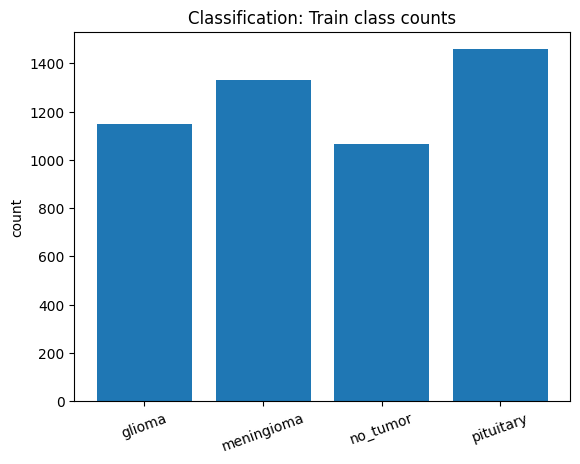

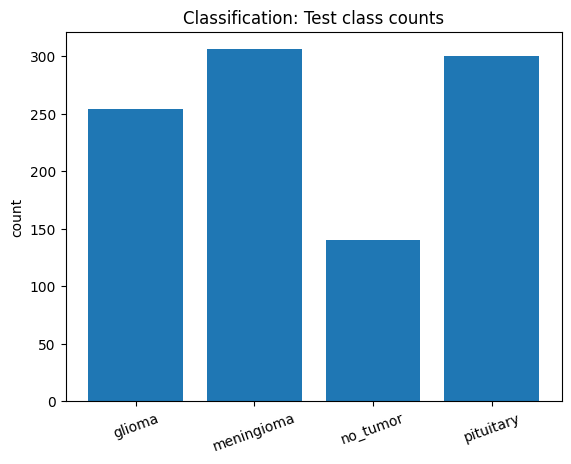

In [ ]:
plt.figure()
plt.bar(df_counts["class"], df_counts["train"])
plt.title("Classification: Train class counts")
plt.xticks(rotation=20)
plt.ylabel("count")
plt.show()

plt.figure()
plt.bar(df_counts["class"], df_counts["test"])
plt.title("Classification: Test class counts")
plt.xticks(rotation=20)
plt.ylabel("count")
plt.show()

Show sample images (classification)

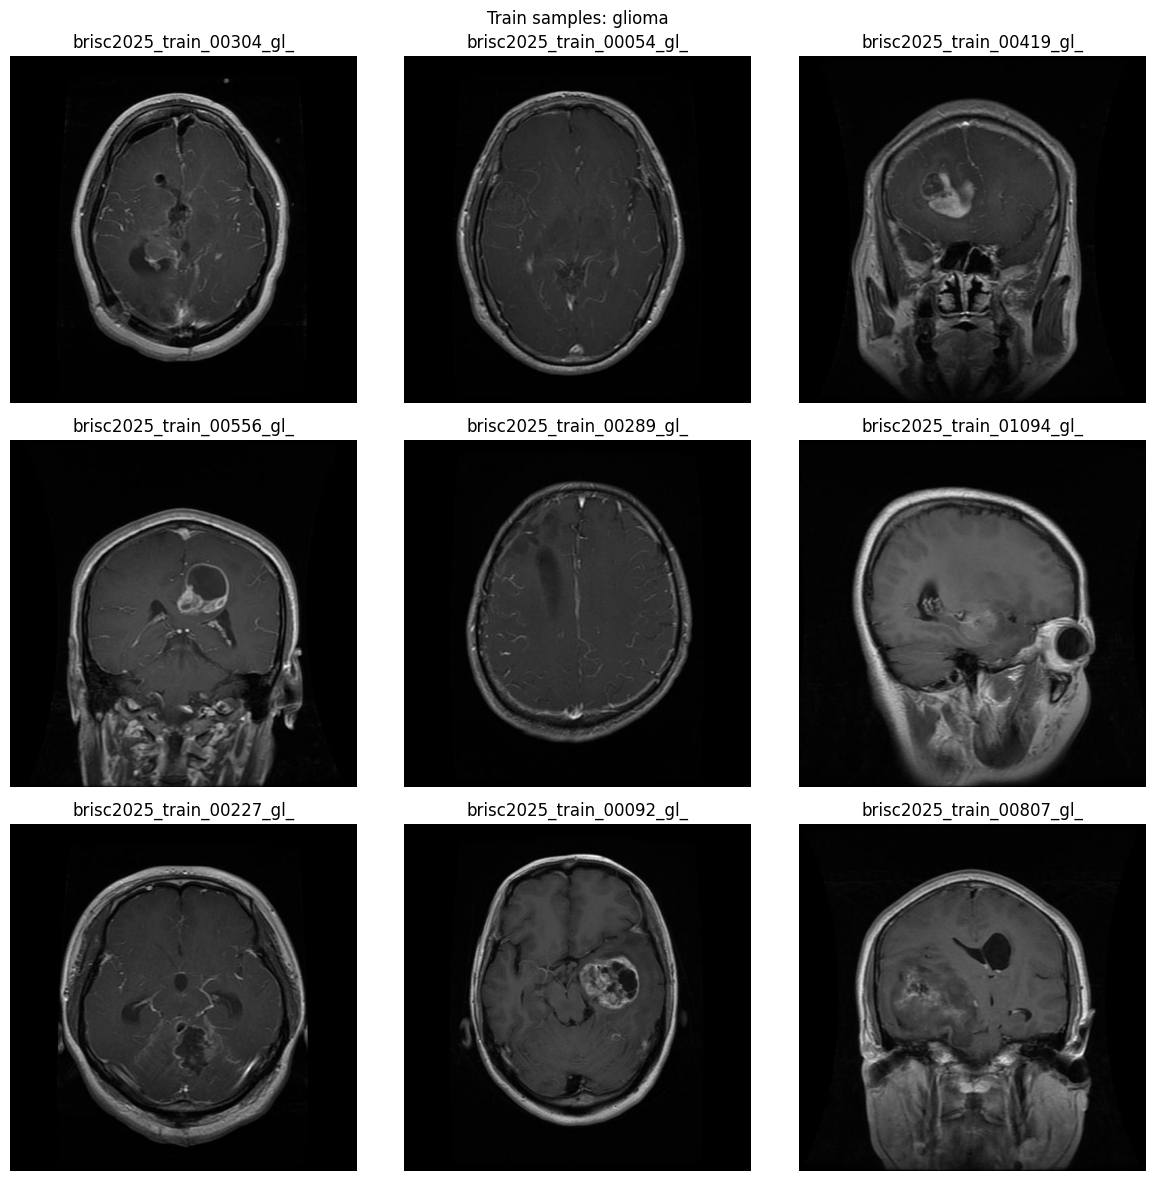

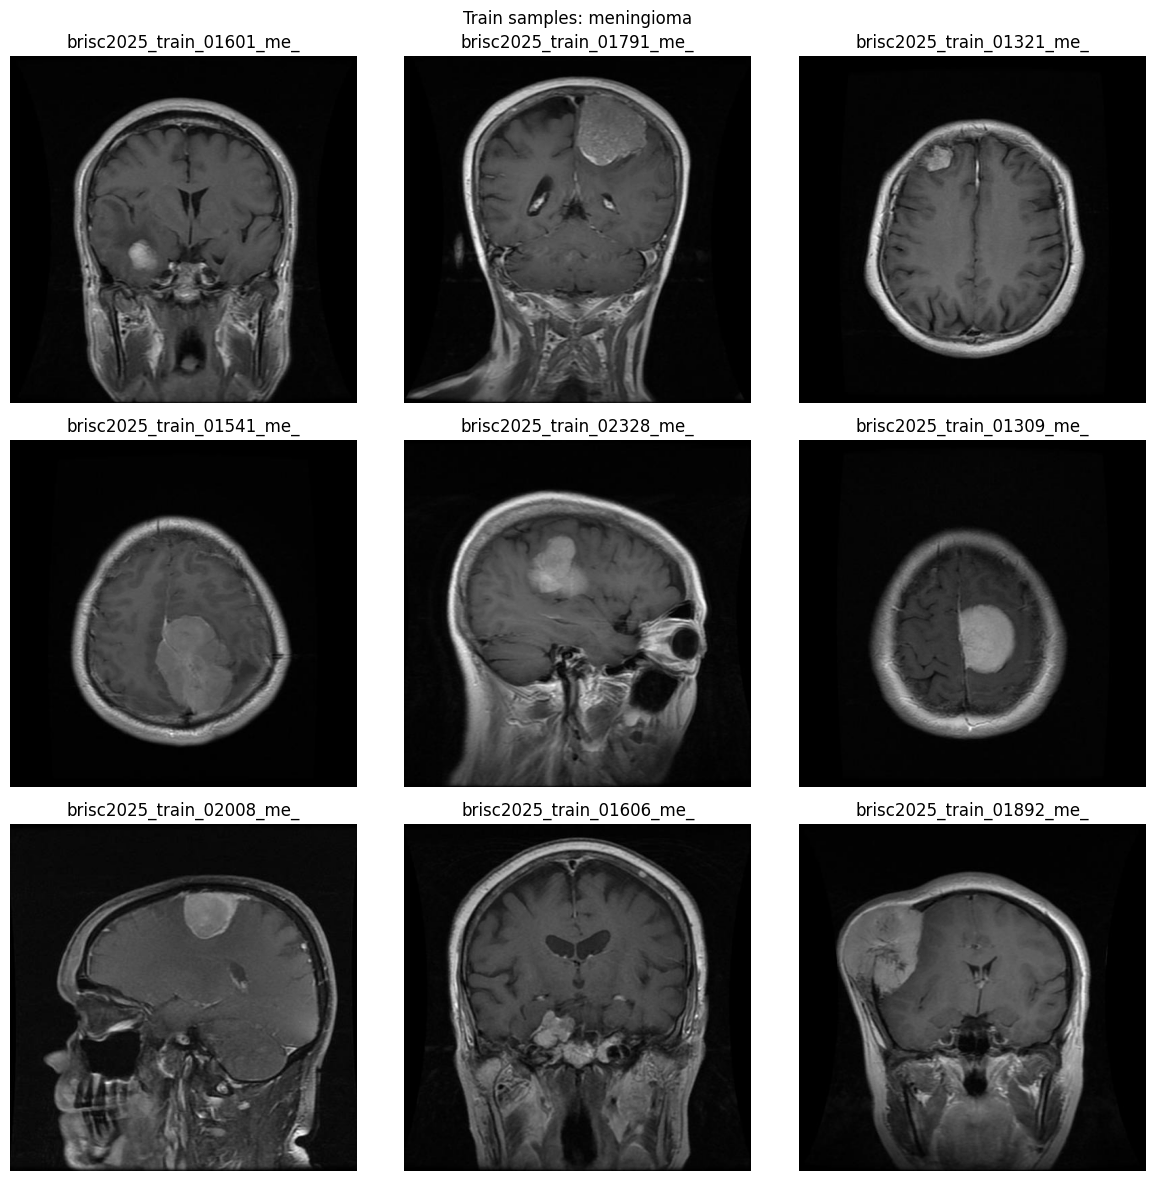

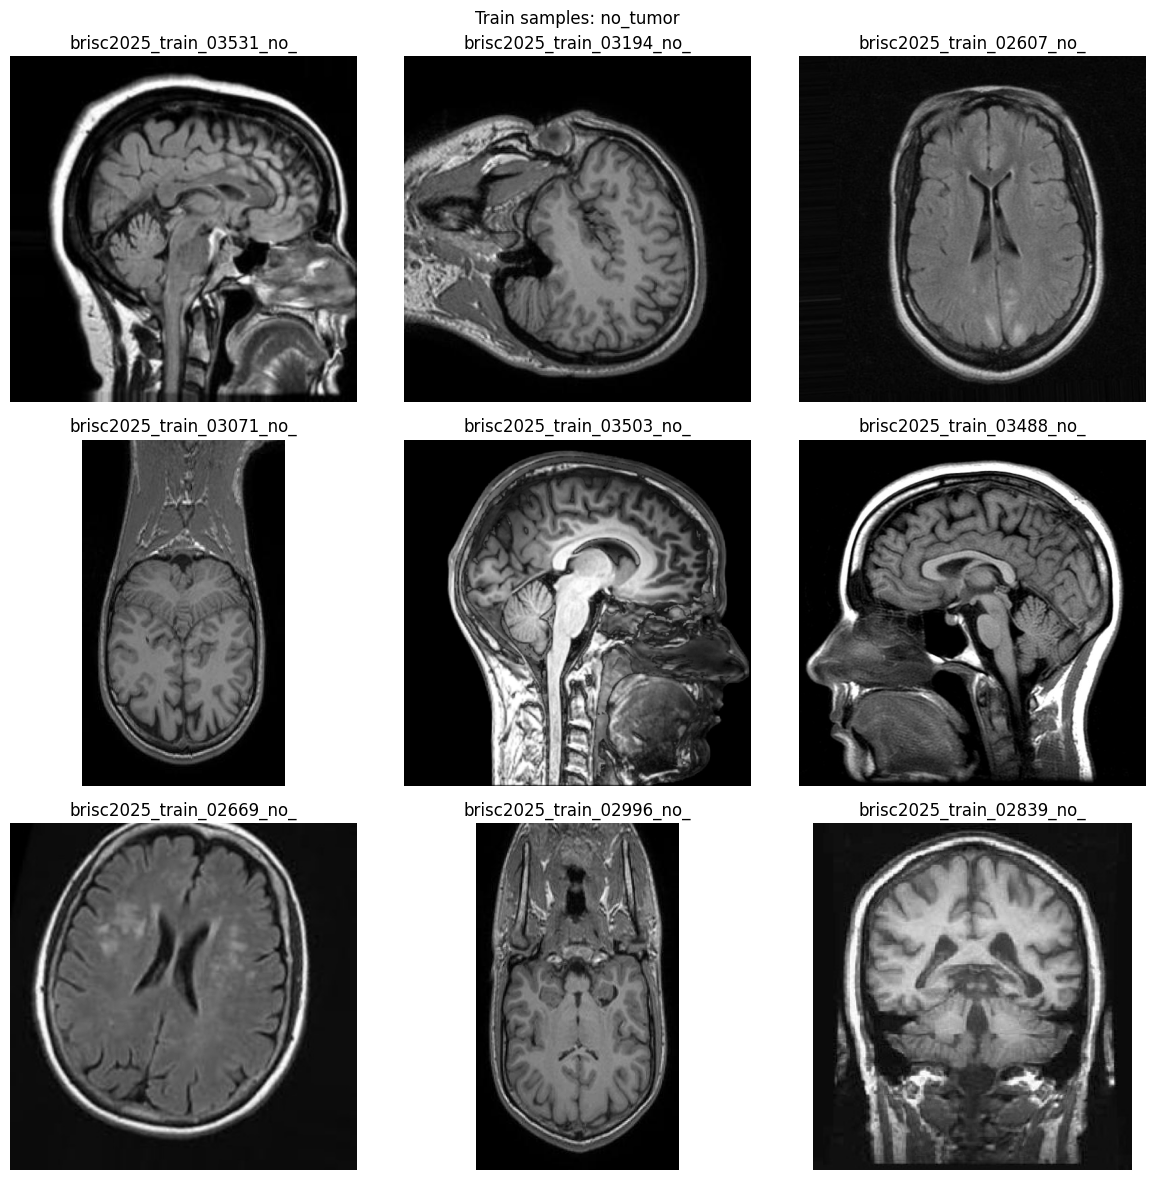

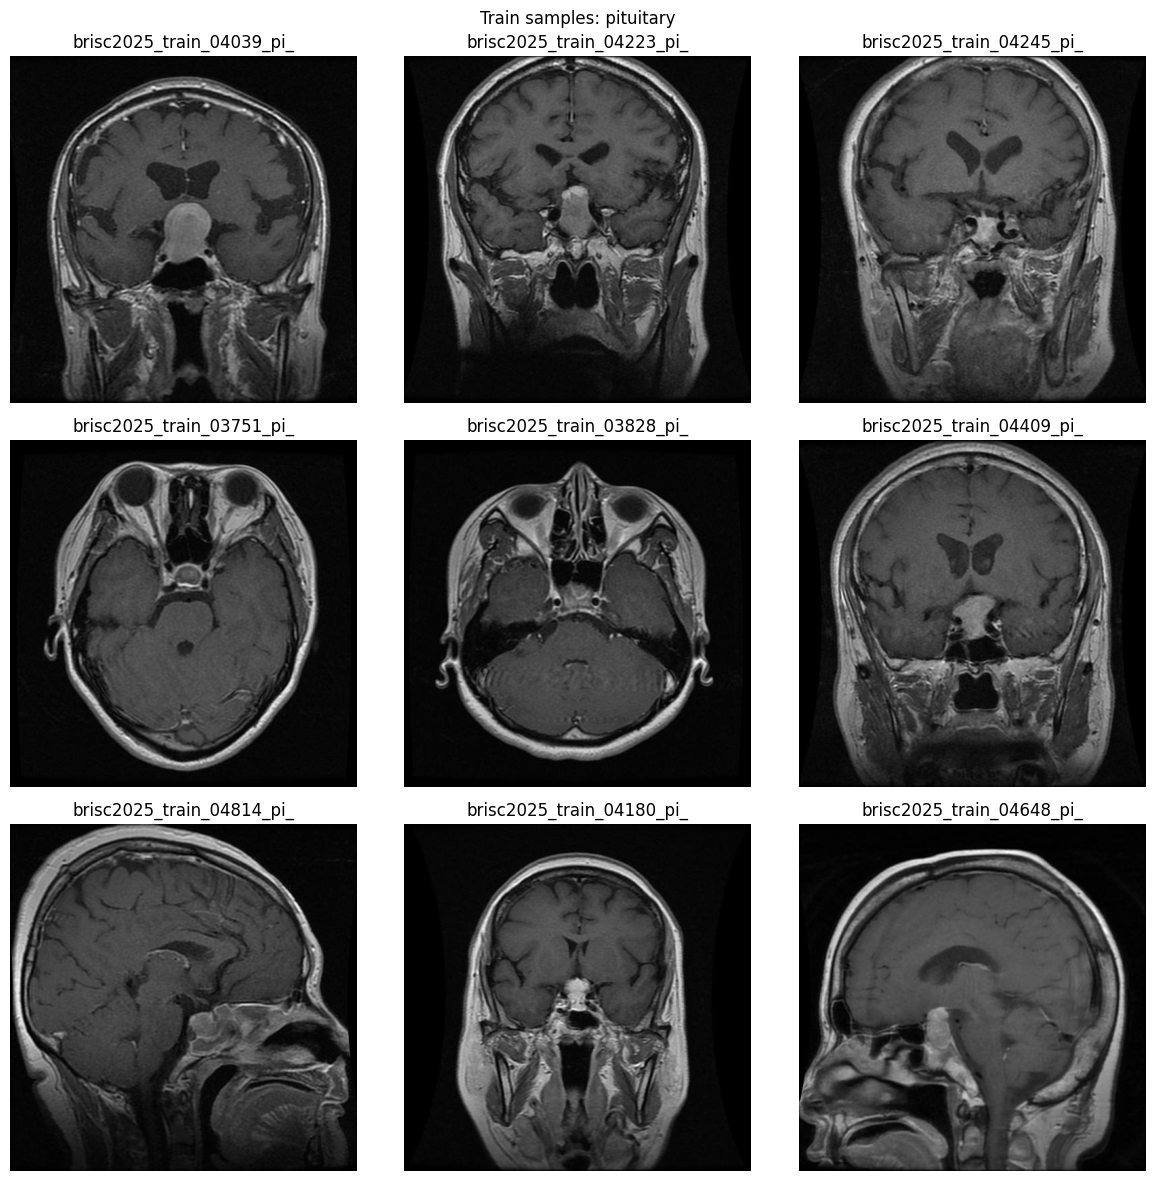

In [ ]:
def sample_images_from_class(split_dir, class_name, k=9):
    class_dir = os.path.join(split_dir, class_name)
    files = [f for f in os.listdir(class_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    files = random.sample(files, k=min(k, len(files)))
    return [os.path.join(class_dir, f) for f in files]

def show_grid(paths, title="", cols=3):
    n = len(paths)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*4, rows*4))
    for i, p in enumerate(paths):
        img = Image.open(p).convert("L")
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(os.path.basename(p)[:25])
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

cls_train = f"{root}/classification_task/train"
for c in classes:
    imgs = sample_images_from_class(cls_train, c, k=9)
    show_grid(imgs, title=f"Train samples: {c}", cols=3)

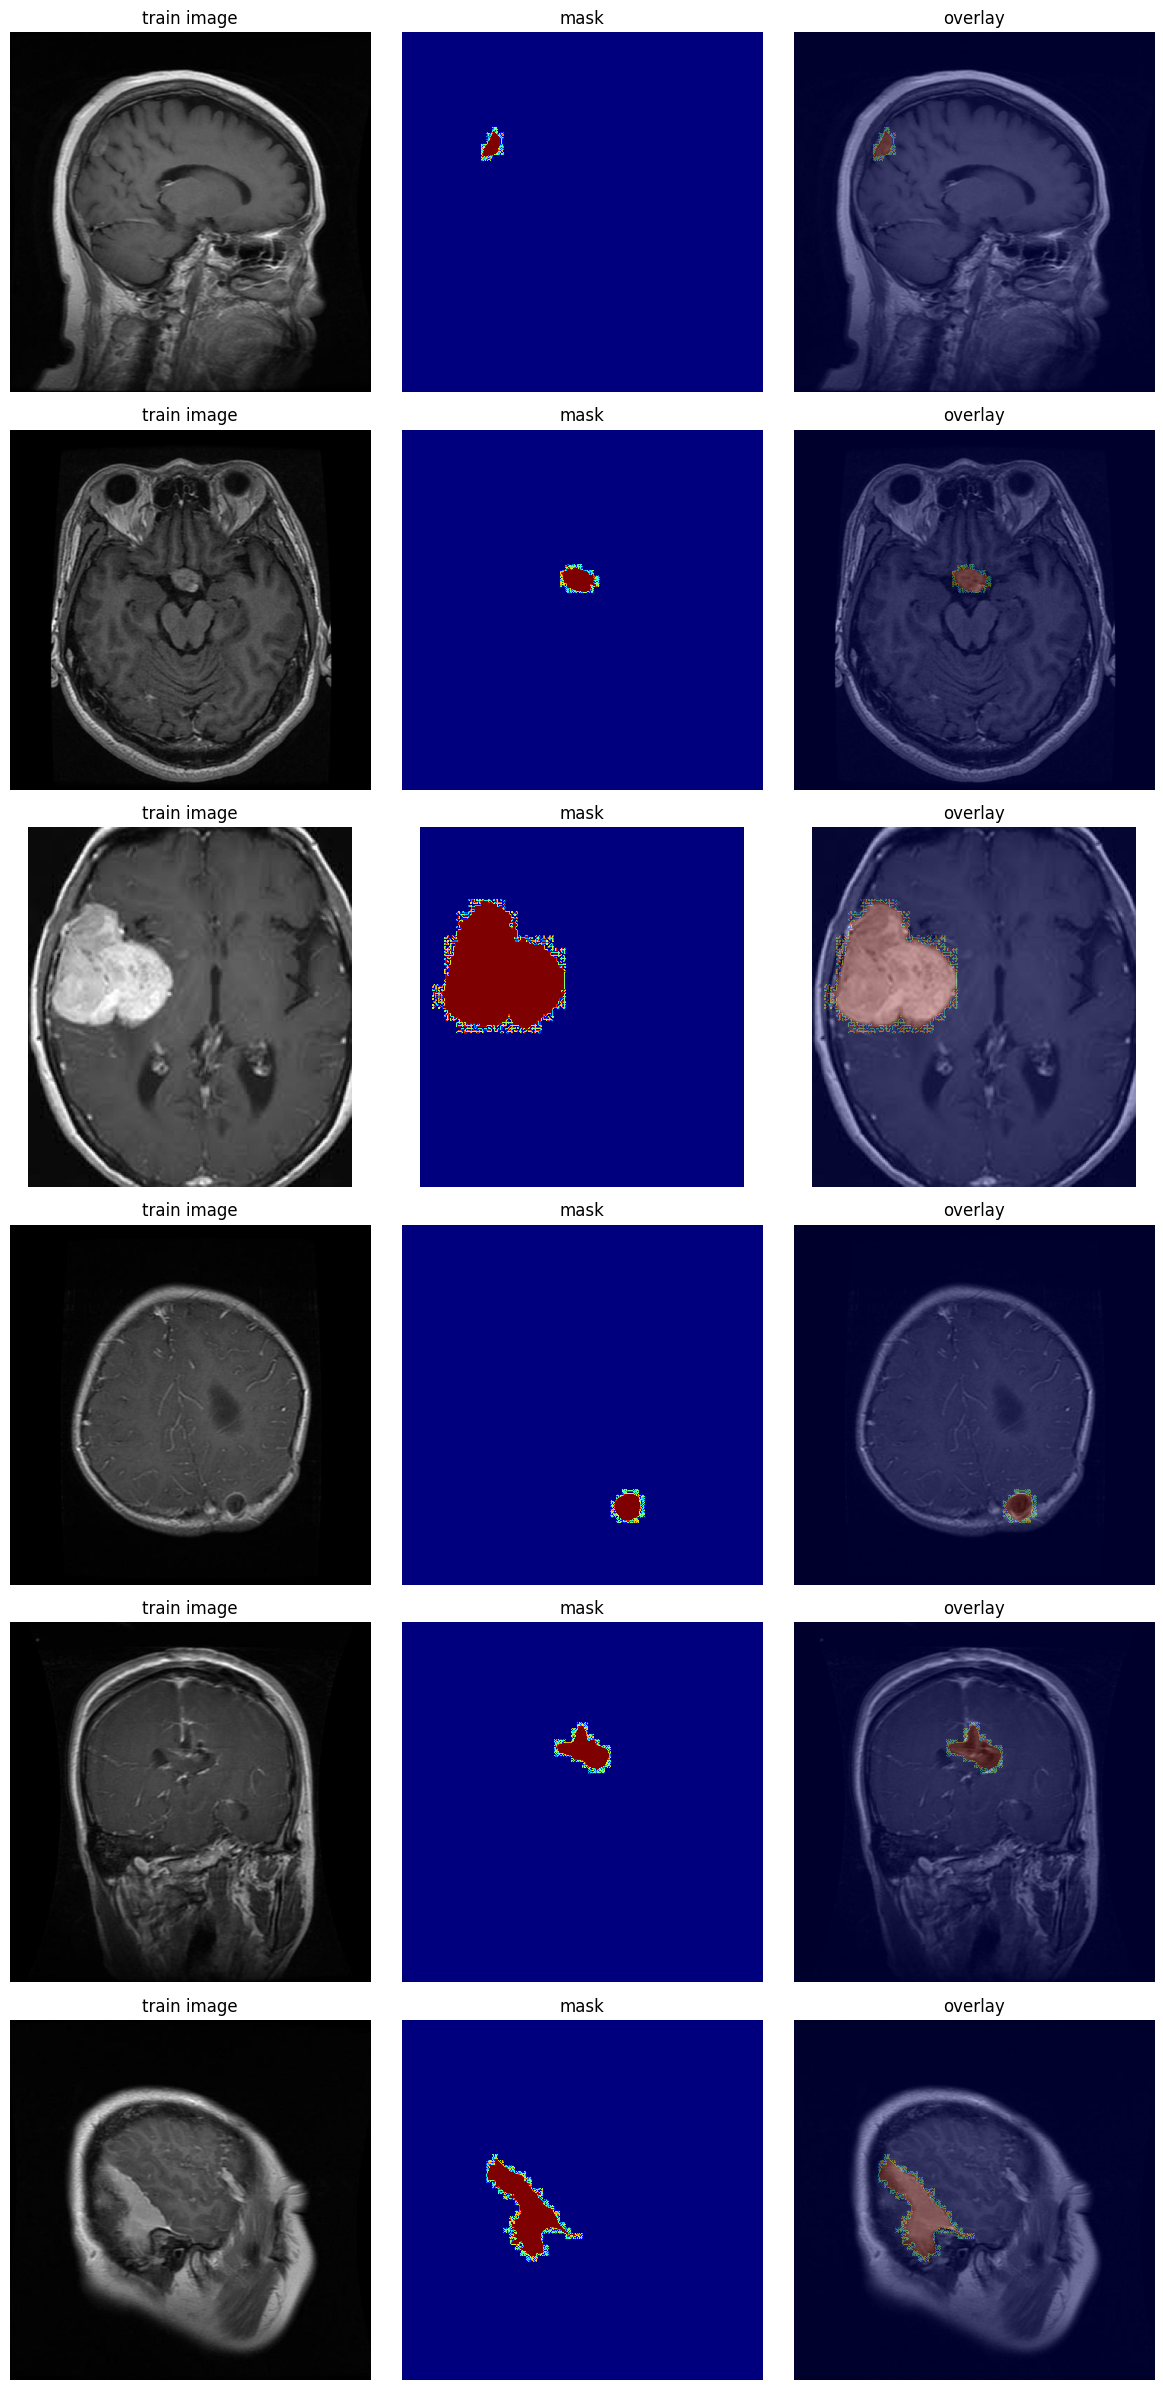

In [ ]:
def show_seg_overlay(root, split="train", k=6, img_size=None):
    img_dir = f"{root}/segmentation_task/{split}/images"
    msk_dir = f"{root}/segmentation_task/{split}/masks"
    files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    files = random.sample(files, k=min(k, len(files)))

    plt.figure(figsize=(12, 4*k))
    for i, f in enumerate(files):
        base = os.path.splitext(f)[0]
        ip = os.path.join(img_dir, f)
        mp = os.path.join(msk_dir, base + ".png")

        img = Image.open(ip).convert("L")
        msk = Image.open(mp).convert("L") if os.path.exists(mp) else None

        if img_size is not None:
            img = img.resize(img_size)
            if msk is not None:
                msk = msk.resize(img_size)

        img_np = np.array(img)
        plt.subplot(k, 3, 3*i+1)
        plt.imshow(img_np, cmap="gray"); plt.title(f"{split} image"); plt.axis("off")

        plt.subplot(k, 3, 3*i+2)
        if msk is None:
            plt.imshow(np.zeros_like(img_np), cmap="jet"); plt.title("mask missing"); plt.axis("off")
        else:
            plt.imshow(np.array(msk) > 0, cmap="jet"); plt.title("mask"); plt.axis("off")

        plt.subplot(k, 3, 3*i+3)
        plt.imshow(img_np, cmap="gray")
        if msk is not None:
            plt.imshow((np.array(msk) > 0).astype(float), cmap="jet", alpha=0.35)
        plt.title("overlay"); plt.axis("off")

    plt.tight_layout()
    plt.show()

show_seg_overlay(root, split="train", k=6)

# Label maps

In [ ]:
@dataclass
class LabelMap:
    labels: List[str]
    label_to_id: Dict[str, int]
    id_to_label: Dict[int, str]

def get_label_map_from_cls_train_dir(cls_train_dir: str) -> LabelMap:
    labels = sorted(
        d for d in os.listdir(cls_train_dir)
        if os.path.isdir(os.path.join(cls_train_dir, d))
    )
    label_to_id = {lab: i for i, lab in enumerate(labels)}
    id_to_label = {i: lab for lab, i in label_to_id.items()}
    return LabelMap(labels, label_to_id, id_to_label)

label_map = get_label_map_from_cls_train_dir(paths.cls_train_dir)
print("LABELS:", label_map.labels)


LABELS: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


# Dataframe builders and Split

In [ ]:
CODE_TO_LABEL = {"gl": "glioma", "me": "meningioma", "pi": "pituitary", "nt": "no_tumor"}

def tumor_label_from_seg_filename(fname: str) -> str:
    parts = os.path.basename(fname).split("_")
    if len(parts) < 4:
        return "unknown"
    return CODE_TO_LABEL.get(parts[3].lower(), "unknown")

def build_seg_df(img_dir: str, msk_dir: str) -> pd.DataFrame:
    recs = []
    for fname in sorted(os.listdir(img_dir)):
        if not fname.lower().endswith((".jpg",".jpeg",".png")):
            continue
        base = os.path.splitext(fname)[0]
        img_path = os.path.join(img_dir, fname)
        msk_path = os.path.join(msk_dir, base + ".png")
        if not os.path.exists(msk_path):
            continue
        recs.append({
            "img_path": img_path,
            "msk_path": msk_path,
            "label": tumor_label_from_seg_filename(fname),
        })
    df = pd.DataFrame(recs)
    if len(df) == 0:
        raise RuntimeError("No segmentation pairs found.")
    return df

def build_cls_df_from_folders(split_dir: str) -> pd.DataFrame:
    class_names = sorted(
        d for d in os.listdir(split_dir)
        if os.path.isdir(os.path.join(split_dir, d))
    )
    recs = []
    for cls in class_names:
        cls_dir = os.path.join(split_dir, cls)
        for fname in sorted(os.listdir(cls_dir)):
            if fname.lower().endswith((".jpg",".jpeg",".png")):
                recs.append({"img_path": os.path.join(cls_dir, fname), "label": cls})
    df = pd.DataFrame(recs)
    if len(df) == 0:
        raise RuntimeError("No classification images found.")
    return df

def stratified_split(df: pd.DataFrame, val_size: float = 0.2, seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if "label" not in df.columns or df["label"].nunique() <= 1:
        tr, va = train_test_split(df, test_size=val_size, random_state=seed, shuffle=True)
    else:
        tr, va = train_test_split(df, test_size=val_size, random_state=seed, stratify=df["label"])
    return tr.reset_index(drop=True), va.reset_index(drop=True)

seg_df_train_full = build_seg_df(paths.seg_train_img_dir, paths.seg_train_msk_dir)
seg_df_test       = build_seg_df(paths.seg_test_img_dir,  paths.seg_test_msk_dir)
seg_train_df, seg_val_df = stratified_split(seg_df_train_full, val_size=0.2, seed=42)

cls_df_train_full = build_cls_df_from_folders(paths.cls_train_dir)
cls_train_df, cls_val_df = stratified_split(cls_df_train_full, val_size=0.2, seed=42)
cls_df_test_labeled = build_cls_df_from_folders(paths.cls_test_dir)

print("Seg train/val/test:", len(seg_train_df), len(seg_val_df), len(seg_df_test))
print("Cls train/val/test:", len(cls_train_df), len(cls_val_df), len(cls_df_test_labeled))


Seg train/val/test: 3146 787 860
Cls train/val/test: 4000 1000 1000


# Datasets Pre Processing

In [ ]:
class BriscSegDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_size=(384, 384), augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.augment = augment

    def __len__(self): return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("L")
        msk = Image.open(row["msk_path"]).convert("L")

        img = TF.resize(img, self.img_size, interpolation=InterpolationMode.BILINEAR)
        msk = TF.resize(msk, self.img_size, interpolation=InterpolationMode.NEAREST)

        x = TF.to_tensor(img)
        m = (np.array(msk, dtype=np.uint8) > 0).astype(np.float32)
        y = torch.from_numpy(m).unsqueeze(0)

        if self.augment:
            if random.random() < 0.5:
                x = torch.flip(x, dims=[2]); y = torch.flip(y, dims=[2])
            if random.random() < 0.5:
                x = torch.flip(x, dims=[1]); y = torch.flip(y, dims=[1])

        return x, y

class BriscClsDatasetGray(Dataset):
    def __init__(self, df: pd.DataFrame, label_map: LabelMap, img_size=(384, 384), augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.label_map = label_map
        self.img_size = img_size
        self.augment = augment
        self.jitter = T.ColorJitter(brightness=0.15, contrast=0.15)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = row["img_path"]
        y = self.label_map.label_to_id[row["label"]]

        img = Image.open(img_path).convert("L")
        img = TF.resize(img, self.img_size, interpolation=InterpolationMode.BILINEAR)

        if self.augment:
            angle = random.uniform(-10, 10)
            img = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR, fill=0)
            if random.random() < 0.5:
                img = TF.hflip(img)
            img = self.jitter(img)

        x = TF.to_tensor(img)
        if self.augment and random.random() < 0.15:
            x = (x + 0.03 * torch.randn_like(x)).clamp(0, 1)

        return x, torch.tensor(y, dtype=torch.long)

class BriscClsDatasetRGB(Dataset):
    def __init__(self, df: pd.DataFrame, label_map: LabelMap, transform: T.Compose):
        self.df = df.reset_index(drop=True)
        self.label_map = label_map
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = row["img_path"]
        y = self.label_map.label_to_id[row["label"]]
        img = Image.open(img_path).convert("RGB")
        x = self.transform(img)
        return x, torch.tensor(y, dtype=torch.long)


# Models

U-Net

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base*2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.enc4 = DoubleConv(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)

        self.out = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))

        d4 = self.up4(b); d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.up3(d4); d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3); d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2); d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.out(d1)

Att U net

In [ ]:
class AttentionGate(nn.Module):
    def __init__(self, F_g: int, F_l: int, F_int: int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        alpha = self.psi(psi)
        return x * alpha

class AttentionUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base*2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.enc4 = DoubleConv(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.att4 = AttentionGate(base*8, base*8, base*4)
        self.dec4 = DoubleConv(base*16, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.att3 = AttentionGate(base*4, base*4, base*2)
        self.dec3 = DoubleConv(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.att2 = AttentionGate(base*2, base*2, base)
        self.dec2 = DoubleConv(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.att1 = AttentionGate(base, base, max(1, base//2))
        self.dec1 = DoubleConv(base*2, base)

        self.out = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))

        d4 = self.up4(b); e4a = self.att4(e4, d4); d4 = self.dec4(torch.cat([d4, e4a], dim=1))
        d3 = self.up3(d4); e3a = self.att3(e3, d3); d3 = self.dec3(torch.cat([d3, e3a], dim=1))
        d2 = self.up2(d3); e2a = self.att2(e2, d2); d2 = self.dec2(torch.cat([d2, e2a], dim=1))
        d1 = self.up1(d2); e1a = self.att1(e1, d1); d1 = self.dec1(torch.cat([d1, e1a], dim=1))
        return self.out(d1)

Classifier head

In [ ]:
class UNetEncoder(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base*2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.enc4 = DoubleConv(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base*8, base*16)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))
        return b

class EncoderClassifier(nn.Module):
    def __init__(self, encoder: nn.Module, feat_ch: int, num_classes: int):
        super().__init__()
        self.encoder = encoder
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_ch, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        feat = self.encoder(x)
        feat = self.gap(feat)
        return self.head(feat)

# Losses + Metrics

In [ ]:
BCE = nn.BCEWithLogitsLoss()
CE  = nn.CrossEntropyLoss()

def dice_loss_soft(logits: torch.Tensor, targets: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
    probs = torch.sigmoid(logits)
    p = probs.view(probs.size(0), -1)
    t = targets.view(targets.size(0), -1)
    inter = (p * t).sum(dim=1)
    dice = (2 * inter + eps) / (p.sum(dim=1) + t.sum(dim=1) + eps)
    return 1 - dice.mean()
# total segmentation loss
def seg_loss_fn(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return BCE(logits, targets) + dice_loss_soft(logits, targets)

@torch.no_grad()
def seg_confusion_from_logits(logits: torch.Tensor, targets: torch.Tensor, thr: float = 0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    p = preds.view(-1)
    t = targets.view(-1)
    tp = (p * t).sum().item()
    fp = (p * (1 - t)).sum().item()
    fn = ((1 - p) * t).sum().item()
    tn = ((1 - p) * (1 - t)).sum().item()
    return tp, fp, fn, tn

def seg_metrics_from_confusion(tp, fp, fn, tn, eps: float = 1e-7):
    iou_fg = (tp + eps) / (tp + fp + fn + eps)
    iou_bg = (tn + eps) / (tn + fn + fp + eps)
    miou = 0.5 * (iou_fg + iou_bg)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    pixacc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    return float(miou), float(dice), float(pixacc)

def cls_metrics_from_confmat(cm: np.ndarray, eps: float = 1e-9):
    tp = np.diag(cm).astype(np.float64)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    prec = (tp + eps) / (tp + fp + eps)
    rec  = (tp + eps) / (tp + fn + eps)
    f1   = (2 * prec * rec + eps) / (prec + rec + eps)
    acc  = float(tp.sum() / (cm.sum() + eps))
    return acc, float(prec.mean()), float(rec.mean()), float(f1.mean())


# Train/Eval Loops

Train/Eval loops (Seg)

In [ ]:
def train_seg_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer):
    model.train()
    total_loss, n = 0.0, 0
    tp = fp = fn = tn = 0.0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with AUT():
            logits = model(x)
            loss = seg_loss_fn(logits, y)

        SCALER.scale(loss).backward()
        SCALER.step(optimizer)
        SCALER.update()

        total_loss += float(loss.item()); n += 1
        a, b, c, d = seg_confusion_from_logits(logits.detach(), y)
        tp += a; fp += b; fn += c; tn += d

    miou, dice, pix = seg_metrics_from_confusion(tp, fp, fn, tn)
    return total_loss / max(1, n), miou, dice, pix

@torch.no_grad()
def eval_seg(model: nn.Module, loader: DataLoader):
    model.eval()
    total_loss, n = 0.0, 0
    tp = fp = fn = tn = 0.0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        with AUT():
            logits = model(x)
            loss = seg_loss_fn(logits, y)

        total_loss += float(loss.item()); n += 1
        a, b, c, d = seg_confusion_from_logits(logits, y)
        tp += a; fp += b; fn += c; tn += d

    miou, dice, pix = seg_metrics_from_confusion(tp, fp, fn, tn)
    return total_loss / max(1, n), miou, dice, pix


Train/Eval loops (Cls)

In [ ]:
def train_cls_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, num_classes: int):
    model.train()
    if hasattr(model, "encoder"):
        model.encoder.eval()

    total_loss, n = 0.0, 0
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = CE(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item()); n += 1
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        trues = y.detach().cpu().numpy()
        for t, p in zip(trues, preds):
            cm[t, p] += 1

    acc, mp, mr, mf1 = cls_metrics_from_confmat(cm)
    return total_loss / max(1, n), acc, mp, mr, mf1

@torch.no_grad()
def eval_cls(model: nn.Module, loader: DataLoader, num_classes: int):
    model.eval()
    total_loss, n = 0.0, 0
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        logits = model(x)
        loss = CE(logits, y)

        total_loss += float(loss.item()); n += 1
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        trues = y.detach().cpu().numpy()
        for t, p in zip(trues, preds):
            cm[t, p] += 1

    acc, mp, mr, mf1 = cls_metrics_from_confmat(cm)
    return total_loss / max(1, n), acc, mp, mr, mf1


# DataLoaders

In [ ]:
SEG_IMG_SIZE = (384, 384)
CLS_IMG_SIZE = (384, 384)

seg_train_loader = DataLoader(BriscSegDataset(seg_train_df, SEG_IMG_SIZE, augment=True),
                              batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
seg_val_loader = DataLoader(BriscSegDataset(seg_val_df, SEG_IMG_SIZE, augment=False),
                            batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
seg_test_loader = DataLoader(BriscSegDataset(seg_df_test, SEG_IMG_SIZE, augment=False),
                             batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

cls_train_loader = DataLoader(BriscClsDatasetGray(cls_train_df, label_map, CLS_IMG_SIZE, augment=True),
                              batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
cls_val_loader = DataLoader(BriscClsDatasetGray(cls_val_df, label_map, CLS_IMG_SIZE, augment=False),
                            batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
cls_test_loader = DataLoader(BriscClsDatasetGray(cls_df_test_labeled, label_map, CLS_IMG_SIZE, augment=False),
                             batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print("Loaders ready.")


Loaders ready.


# Training

Stage-1 Segmentation Training (U-Net)

In [ ]:
MODEL_TYPE = "unet"
EPOCHS = 40
LR = 1e-3
PATIENCE = 7

if MODEL_TYPE == "unet":
    seg_model = UNet(in_ch=1, out_ch=1, base=32).to(DEVICE)
    seg_ckpt_path = os.path.join(paths.out_dir, "stage1_unet_seg_best.pth")
else:
    seg_model = AttentionUNet(in_ch=1, out_ch=1, base=32).to(DEVICE)
    seg_ckpt_path = os.path.join(paths.out_dir, "stage1_attunet_seg_best.pth")

optimizer = torch.optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

best_val_dice = -1.0
no_improve = 0
hist = {"train_loss": [], "val_loss": [], "train_dice": [], "val_dice": []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_miou, tr_dice, _ = train_seg_one_epoch(seg_model, seg_train_loader, optimizer)
    va_loss, va_miou, va_dice, _ = eval_seg(seg_model, seg_val_loader)
    scheduler.step(va_dice)

    hist["train_loss"].append(tr_loss); hist["val_loss"].append(va_loss)
    hist["train_dice"].append(tr_dice); hist["val_dice"].append(va_dice)

    lr_now = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d}/{EPOCHS} | lr={lr_now:.2e} | "
          f"loss {tr_loss:.4f}/{va_loss:.4f} | dice {tr_dice:.4f}/{va_dice:.4f} | miou {tr_miou:.4f}/{va_miou:.4f}")

    if va_dice > best_val_dice + 1e-4:
        best_val_dice = va_dice
        no_improve = 0
        torch.save(seg_model.state_dict(), seg_ckpt_path)
        print(f"Saved best: {seg_ckpt_path} (val_dice={best_val_dice:.4f})")
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print("Early stopping.")
        break

# Load best + summarize
seg_model.load_state_dict(torch.load(seg_ckpt_path, map_location=DEVICE))
tr = eval_seg(seg_model, seg_train_loader)
va = eval_seg(seg_model, seg_val_loader)
te = eval_seg(seg_model, seg_test_loader)

seg_summary = pd.DataFrame(
    [["train", *tr], ["val", *va], ["test", *te]],
    columns=["split", "loss", "mIoU", "dice", "pixel_accuracy"],
)
print("\n=== Stage-1 Summary ===")
print(seg_summary.to_string(index=False))


Epoch 01/40 | lr=1.00e-03 | loss 0.8541/0.6069 | dice 0.4272/0.5125 | miou 0.6251/0.6623
Saved best: /kaggle/working/stage1_unet_seg_best.pth (val_dice=0.5125)
Epoch 02/40 | lr=1.00e-03 | loss 0.5581/0.5845 | dice 0.5727/0.5263 | miou 0.6933/0.6694
Saved best: /kaggle/working/stage1_unet_seg_best.pth (val_dice=0.5263)
Epoch 03/40 | lr=1.00e-03 | loss 0.4936/0.6674 | dice 0.6217/0.5070 | miou 0.7190/0.6634
Epoch 04/40 | lr=1.00e-03 | loss 0.4519/0.4522 | dice 0.6584/0.6768 | miou 0.7395/0.7506
Saved best: /kaggle/working/stage1_unet_seg_best.pth (val_dice=0.6768)
Epoch 05/40 | lr=1.00e-03 | loss 0.4350/0.4660 | dice 0.6707/0.6215 | miou 0.7465/0.7190
Epoch 06/40 | lr=1.00e-03 | loss 0.4112/0.6220 | dice 0.6846/0.5095 | miou 0.7547/0.6628
Epoch 07/40 | lr=1.00e-03 | loss 0.3886/0.4503 | dice 0.7041/0.6362 | miou 0.7665/0.7263
Epoch 08/40 | lr=5.00e-04 | loss 0.3719/0.4788 | dice 0.7159/0.6068 | miou 0.7738/0.7108
Epoch 09/40 | lr=5.00e-04 | loss 0.3395/0.3596 | dice 0.7395/0.7310 | miou 

Plot Stage-1 curves

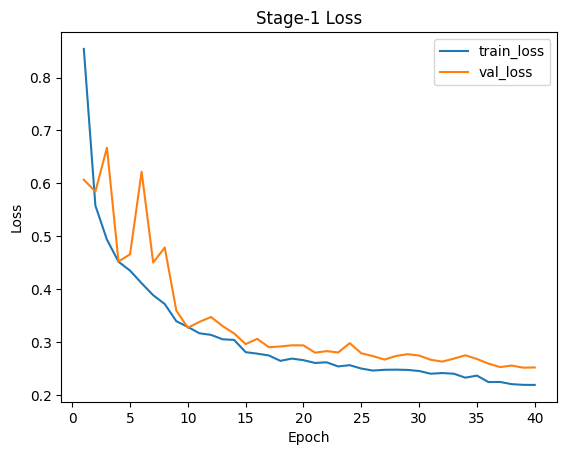

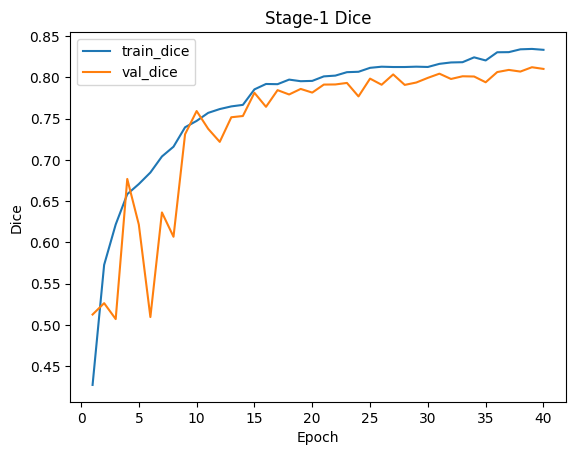

In [ ]:
ep = np.arange(1, len(hist["train_loss"]) + 1)

plt.figure()
plt.plot(ep, hist["train_loss"], label="train_loss")
plt.plot(ep, hist["val_loss"], label="val_loss")
plt.title("Stage-1 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(ep, hist["train_dice"], label="train_dice")
plt.plot(ep, hist["val_dice"], label="val_dice")
plt.title("Stage-1 Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.show()


Build frozen encoder from Stage-1 checkpoint

In [ ]:
def load_frozen_encoder_from_stage1(stage1_ckpt_path: str, base: int = 32) -> UNetEncoder:
    enc = UNetEncoder(in_ch=1, base=base)
    state = torch.load(stage1_ckpt_path, map_location="cpu")
    enc_state = {k: v for k, v in state.items() if k.startswith(("enc1", "enc2", "enc3", "enc4", "bottleneck"))}
    enc.load_state_dict(enc_state, strict=False)
    for p in enc.parameters():
        p.requires_grad = False
    return enc

encoder = load_frozen_encoder_from_stage1(seg_ckpt_path, base=32)
print("Encoder loaded + frozen.")


Encoder loaded + frozen.


Stage-2 Classification Training (using frozen encoder)

In [ ]:
cls_model = EncoderClassifier(encoder, feat_ch=32*16, num_classes=len(label_map.labels)).to(DEVICE)
cls_ckpt_path = os.path.join(paths.out_dir, "stage2_cls_best.pth")

optimizer = torch.optim.Adam([p for p in cls_model.parameters() if p.requires_grad], lr=1e-3)

EPOCHS = 50
best_val_f1 = -1.0
cls_hist = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}

for epoch in range(1, EPOCHS + 1):
    tr = train_cls_one_epoch(cls_model, cls_train_loader, optimizer, num_classes=len(label_map.labels))
    va = eval_cls(cls_model, cls_val_loader, num_classes=len(label_map.labels))

    cls_hist["train_loss"].append(tr[0]); cls_hist["val_loss"].append(va[0])
    cls_hist["train_f1"].append(tr[4]); cls_hist["val_f1"].append(va[4])

    print(f"Epoch {epoch:02d}/{EPOCHS} | loss {tr[0]:.4f}/{va[0]:.4f} | acc {tr[1]:.4f}/{va[1]:.4f} | F1 {tr[4]:.4f}/{va[4]:.4f}")

    if va[4] > best_val_f1:
        best_val_f1 = va[4]
        torch.save(cls_model.state_dict(), cls_ckpt_path)
        print(f" Saved best: {cls_ckpt_path} (val_F1={best_val_f1:.4f})")

# Evaluate best on train/val/test (your test is labeled)
cls_model.load_state_dict(torch.load(cls_ckpt_path, map_location=DEVICE))
tr_eval = eval_cls(cls_model, cls_train_loader, len(label_map.labels))
va_eval = eval_cls(cls_model, cls_val_loader,   len(label_map.labels))
te_eval = eval_cls(cls_model, cls_test_loader,  len(label_map.labels))

cls_summary = pd.DataFrame(
    [["train", *tr_eval], ["val", *va_eval], ["test", *te_eval]],
    columns=["split", "loss", "accuracy", "precision_macro", "recall_macro", "f1_macro"],
)
print("\n=== Stage-2 Summary ===")
print(cls_summary.to_string(index=False))


Epoch 01/50 | loss 1.1565/0.9355 | acc 0.4900/0.6110 | F1 0.4780/0.6016
 Saved best: /kaggle/working/stage2_cls_best.pth (val_F1=0.6016)
Epoch 02/50 | loss 0.9612/0.8490 | acc 0.6057/0.6890 | F1 0.6010/0.6692
 Saved best: /kaggle/working/stage2_cls_best.pth (val_F1=0.6692)
Epoch 03/50 | loss 0.8863/0.7622 | acc 0.6347/0.7260 | F1 0.6292/0.7338
 Saved best: /kaggle/working/stage2_cls_best.pth (val_F1=0.7338)
Epoch 04/50 | loss 0.8426/0.7035 | acc 0.6660/0.7630 | F1 0.6630/0.7586
 Saved best: /kaggle/working/stage2_cls_best.pth (val_F1=0.7586)
Epoch 05/50 | loss 0.8231/0.6768 | acc 0.6715/0.7340 | F1 0.6680/0.7239
Epoch 06/50 | loss 0.7827/0.6360 | acc 0.6972/0.7780 | F1 0.6939/0.7779
 Saved best: /kaggle/working/stage2_cls_best.pth (val_F1=0.7779)
Epoch 07/50 | loss 0.7621/0.6169 | acc 0.6967/0.7740 | F1 0.6947/0.7831
 Saved best: /kaggle/working/stage2_cls_best.pth (val_F1=0.7831)
Epoch 08/50 | loss 0.7296/0.5927 | acc 0.7140/0.7960 | F1 0.7119/0.7911
 Saved best: /kaggle/working/stage

Plot Stage-2 curves

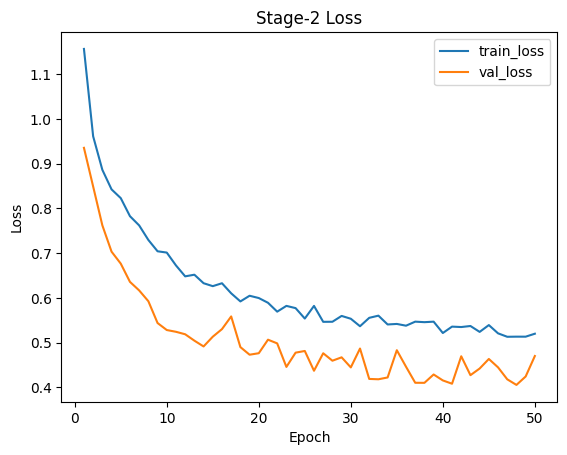

In [ ]:
ep = np.arange(1, len(cls_hist["train_loss"]) + 1)

plt.figure()
plt.plot(ep, cls_hist["train_loss"], label="train_loss")
plt.plot(ep, cls_hist["val_loss"], label="val_loss")
plt.title("Stage-2 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



Stage-1 Segmentation Training (Attention U-Net)

In [ ]:
MODEL_TYPE = "attunet"
EPOCHS = 40
LR = 1e-3
PATIENCE = 7

if MODEL_TYPE == "unet":
    seg_model = UNet(in_ch=1, out_ch=1, base=32).to(DEVICE)
    seg_ckpt_path = os.path.join(paths.out_dir, "stage1_unet_seg_best.pth")
else:
    seg_model = AttentionUNet(in_ch=1, out_ch=1, base=32).to(DEVICE)
    seg_ckpt_path = os.path.join(paths.out_dir, "stage1_attunet_seg_best.pth")

optimizer = torch.optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

best_val_dice = -1.0
no_improve = 0
hist = {"train_loss": [], "val_loss": [], "train_dice": [], "val_dice": []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_miou, tr_dice, _ = train_seg_one_epoch(seg_model, seg_train_loader, optimizer)
    va_loss, va_miou, va_dice, _ = eval_seg(seg_model, seg_val_loader)
    scheduler.step(va_dice)

    hist["train_loss"].append(tr_loss); hist["val_loss"].append(va_loss)
    hist["train_dice"].append(tr_dice); hist["val_dice"].append(va_dice)

    lr_now = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d}/{EPOCHS} | lr={lr_now:.2e} | "
          f"loss {tr_loss:.4f}/{va_loss:.4f} | dice {tr_dice:.4f}/{va_dice:.4f} | miou {tr_miou:.4f}/{va_miou:.4f}")

    if va_dice > best_val_dice + 1e-4:
        best_val_dice = va_dice
        no_improve = 0
        torch.save(seg_model.state_dict(), seg_ckpt_path)
        print(f" Saved best: {seg_ckpt_path} (val_dice={best_val_dice:.4f})")
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print("Early stopping.")
        break

# Load best + summarize
seg_model.load_state_dict(torch.load(seg_ckpt_path, map_location=DEVICE))
tr = eval_seg(seg_model, seg_train_loader)
va = eval_seg(seg_model, seg_val_loader)
te = eval_seg(seg_model, seg_test_loader)

seg_summary = pd.DataFrame(
    [["train", *tr], ["val", *va], ["test", *te]],
    columns=["split", "loss", "mIoU", "dice", "pixel_accuracy"],
)
print("\n=== Stage-1 Summary ===")
print(seg_summary.to_string(index=False))


Epoch 01/40 | lr=1.00e-03 | loss 0.9420/1.1137 | dice 0.3594/0.0003 | miou 0.5975/0.4909
 Saved best: /kaggle/working/stage1_attunet_seg_best.pth (val_dice=0.0003)
Epoch 02/40 | lr=1.00e-03 | loss 0.5980/0.6720 | dice 0.5550/0.4881 | miou 0.6845/0.6548
 Saved best: /kaggle/working/stage1_attunet_seg_best.pth (val_dice=0.4881)
Epoch 03/40 | lr=1.00e-03 | loss 0.5092/0.5155 | dice 0.6133/0.6203 | miou 0.7145/0.7189
 Saved best: /kaggle/working/stage1_attunet_seg_best.pth (val_dice=0.6203)
Epoch 04/40 | lr=1.00e-03 | loss 0.4613/0.4448 | dice 0.6486/0.6568 | miou 0.7339/0.7387
 Saved best: /kaggle/working/stage1_attunet_seg_best.pth (val_dice=0.6568)
Epoch 05/40 | lr=1.00e-03 | loss 0.4359/0.4517 | dice 0.6739/0.6545 | miou 0.7485/0.7371
Epoch 06/40 | lr=1.00e-03 | loss 0.4111/0.4157 | dice 0.6898/0.6728 | miou 0.7578/0.7470
 Saved best: /kaggle/working/stage1_attunet_seg_best.pth (val_dice=0.6728)
Epoch 07/40 | lr=1.00e-03 | loss 0.3989/0.3874 | dice 0.6981/0.7026 | miou 0.7628/0.7657
 S

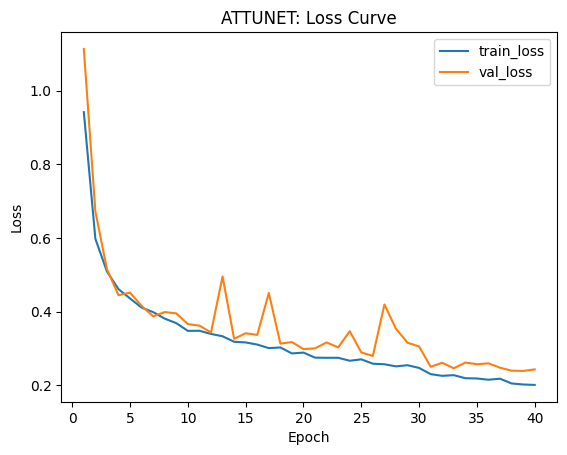

In [ ]:
ep = np.arange(1, len(hist["train_loss"]) + 1)

plt.figure()
plt.plot(ep, hist["train_loss"], label="train_loss")
plt.plot(ep, hist["val_loss"], label="val_loss")
plt.title(f"{MODEL_TYPE.upper()}: Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Inference

In [ ]:

CODE_TO_LABEL = {"gl": "glioma", "me": "meningioma", "pi": "pituitary", "nt": "no_tumor"}

def infer_true_label(image_path: str):
    # Case 1: from classification folder name
    parts = image_path.replace("\\", "/").split("/")
    if "classification_task" in parts:
        i = parts.index("classification_task")
        if i + 2 < len(parts):
            split = parts[i + 1]
            lab   = parts[i + 2]
            if split in ("train", "test"):
                return lab

    # Case 2: from segmentation filename code
    fname = os.path.basename(image_path)
    toks = fname.split("_")
    if len(toks) >= 4:
        code = toks[3].lower()
        return CODE_TO_LABEL.get(code, None)

    return None

def find_gt_mask(image_path: str, data_root: str):
    base = os.path.splitext(os.path.basename(image_path))[0] + ".png"
    candidates = [
        os.path.join(data_root, "segmentation_task/train/masks", base),
        os.path.join(data_root, "segmentation_task/test/masks", base),
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

@torch.no_grad()
def demo_project_inference(
    image_path: str,
    seg_model,
    cls_model,
    label_map,
    img_size=(384, 384),
    thr=0.5,
    data_root="/kaggle/input/brisc2025/brisc2025",
):
    seg_model.eval()
    cls_model.eval()
    device = next(seg_model.parameters()).device

    # --- Load image + "processed" (resize) ---
    img_orig = Image.open(image_path).convert("L")
    img_proc = TF.resize(img_orig, img_size, interpolation=InterpolationMode.BILINEAR)
    x = TF.to_tensor(img_proc).unsqueeze(0).to(device)

    # --- GT mask (if exists) ---
    mask_path = find_gt_mask(image_path, data_root)
    gt_mask = None
    if mask_path is not None:
        m = Image.open(mask_path).convert("L")
        m = TF.resize(m, img_size, interpolation=InterpolationMode.NEAREST)
        gt_mask = (np.array(m) > 0).astype(np.float32)

    # --- Seg prediction ---
    seg_logits = seg_model(x)
    seg_prob = torch.sigmoid(seg_logits)[0, 0].detach().cpu().numpy()
    pred_mask = (seg_prob > thr).astype(np.float32)

    # --- IoU (foreground) ---
    iou = None
    if gt_mask is not None:
        tp = (pred_mask * gt_mask).sum()
        fp = (pred_mask * (1 - gt_mask)).sum()
        fn = ((1 - pred_mask) * gt_mask).sum()
        eps = 1e-7
        iou = float((tp + eps) / (tp + fp + fn + eps))

    # --- Classification prediction + single-image accuracy (if GT label known) ---
    cls_logits = cls_model(x)
    probs = torch.softmax(cls_logits, dim=1)[0].detach().cpu().numpy()
    pred_id = int(np.argmax(probs))
    pred_label = label_map.id_to_label[pred_id]
    pred_conf = float(probs[pred_id])

    true_label = infer_true_label(image_path)
    cls_acc = None
    if true_label is not None:
        cls_acc = 1.0 if pred_label == true_label else 0.0

    # --- Plot
    img_np = np.array(img_proc)
    fig, ax = plt.subplots(2, 3, figsize=(14, 8))

    ax[0, 0].imshow(img_np, cmap="gray"); ax[0, 0].set_title("Original image"); ax[0, 0].axis("off")

    if gt_mask is None:
        ax[0, 1].imshow(np.zeros_like(img_np), cmap="gray")
    else:
        ax[0, 1].imshow(gt_mask, cmap="jet")
    ax[0, 1].set_title("Original mask"); ax[0, 1].axis("off")

    ax[0, 2].imshow(img_np, cmap="gray")
    if gt_mask is not None:
        ax[0, 2].imshow(gt_mask, cmap="jet", alpha=0.35)
    ax[0, 2].set_title("Original image with mask overlay"); ax[0, 2].axis("off")

    ax[1, 0].imshow(img_np, cmap="gray")
    ax[1, 0].set_title("Processed image ")
    ax[1, 0].axis("off")

    ax[1, 1].imshow(pred_mask, cmap="jet"); ax[1, 1].set_title("Predicted mask"); ax[1, 1].axis("off")

    ax[1, 2].imshow(img_np, cmap="gray")
    ax[1, 2].imshow(pred_mask, cmap="jet", alpha=0.35)
    ax[1, 2].set_title("Original image with predicted mask overlay"); ax[1, 2].axis("off")

    # --- Top text includes GIVEN & PREDICTED (what you asked) ---
    given_txt = "N/A" if true_label is None else true_label
    pred_txt = f"{pred_label} ({pred_conf:.2f})"
    acc_txt = "N/A" if cls_acc is None else f"{cls_acc:.2f}"
    iou_txt = "N/A" if iou is None else f"{iou:.3f}"

    fig.suptitle(
        f"given: {given_txt}   predicted: {pred_txt}   classification accuracy - {acc_txt}   IoU - {iou_txt}",
        fontsize=13
    )

    plt.tight_layout()
    plt.show()


Picking a random test image

Random demo image: /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00795_pi_ax_t1.jpg


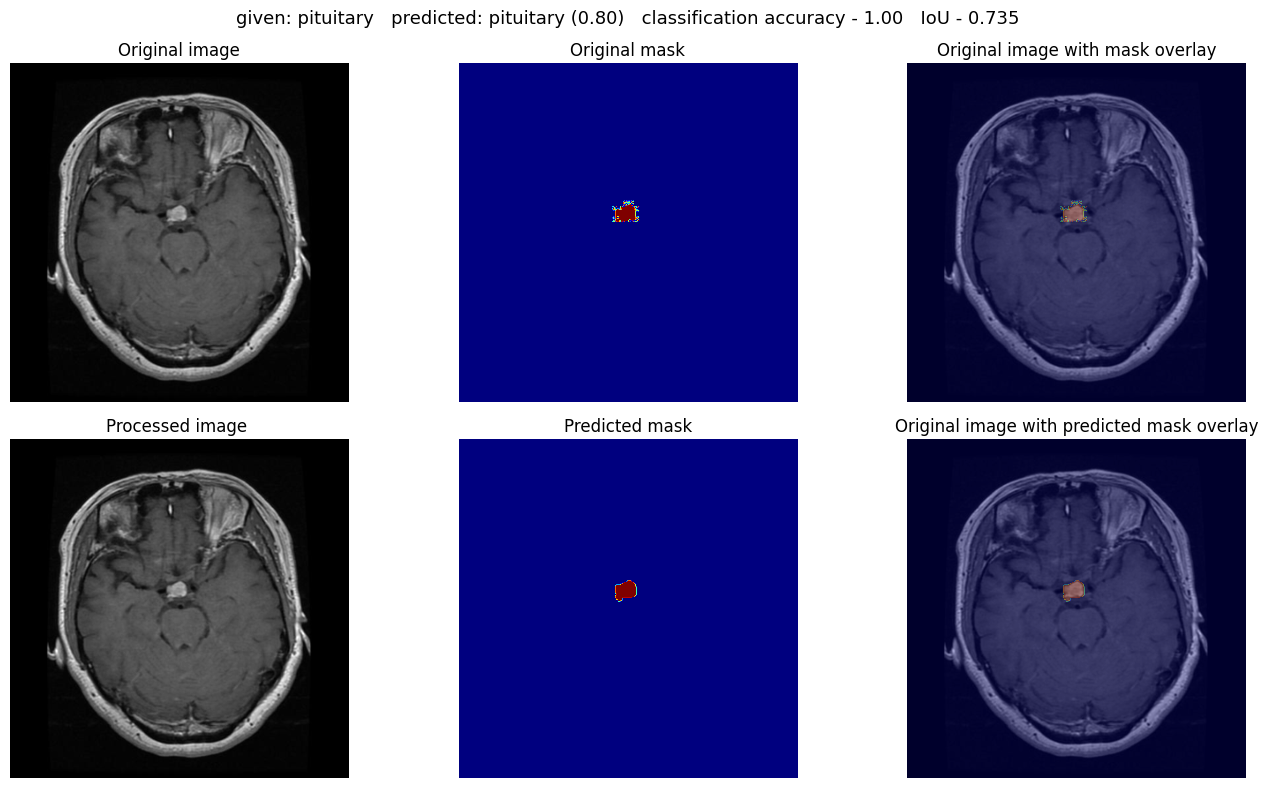

In [ ]:
DATA_ROOT = "/kaggle/input/brisc2025/brisc2025"
IMG_SIZE = (384, 384)

# Pick a random image from segmentation test images
img_dir = f"{DATA_ROOT}/segmentation_task/test/images"
files = [f for f in os.listdir(img_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
DEMO_IMAGE_PATH = os.path.join(img_dir, random.choice(files))

print("Random demo image:", DEMO_IMAGE_PATH)

# Run inference
demo_project_inference(
    image_path=DEMO_IMAGE_PATH,
    seg_model=seg_model,
    cls_model=cls_model,
    label_map=label_map,
    img_size=IMG_SIZE,
    thr=0.5,
    data_root=DATA_ROOT,
)


This cell is for giving a image by myself to Inferance

Manual demo image: /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00027_gl_ax_t1.jpg


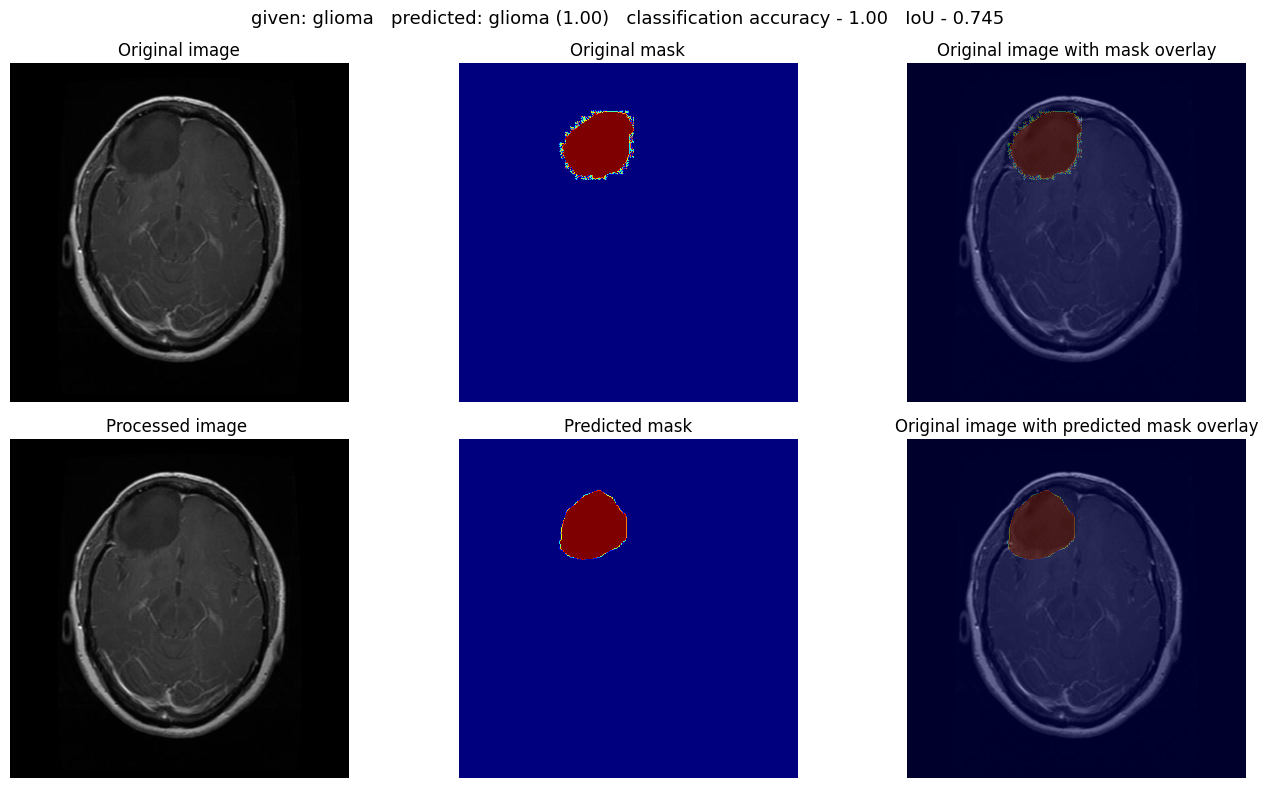

In [ ]:
DATA_ROOT = "/kaggle/input/brisc2025/brisc2025"
IMG_SIZE = (384, 384)

# Paste image path here
DEMO_IMAGE_PATH = "/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00027_gl_ax_t1.jpg"

print("Manual demo image:", DEMO_IMAGE_PATH)

demo_project_inference(
    image_path=DEMO_IMAGE_PATH,
    seg_model=seg_model,
    cls_model=cls_model,
    label_map=label_map,
    img_size=IMG_SIZE,
    thr=0.5,
    data_root=DATA_ROOT,
)


# Bonus

1. From the section “Open-ended design choices”, analyze how the performance changes
when the segmentation head and the classifier head are trained separately compared to
when they are trained together

Joint training approach

In [ ]:

class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class MultiTaskUNet(nn.Module):

    def __init__(self, in_ch=1, base=32, num_classes=4):
        super().__init__()
        # ---- Shared encoder ----
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base * 2)
        self.enc3 = DoubleConv(base * 2, base * 4)
        self.enc4 = DoubleConv(base * 4, base * 8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base * 8, base * 16)

        # ---- Segmentation decoder head ----
        self.up4 = nn.ConvTranspose2d(base * 16, base * 8, 2, stride=2)
        self.dec4 = DoubleConv(base * 16, base * 8)

        self.up3 = nn.ConvTranspose2d(base * 8, base * 4, 2, stride=2)
        self.dec3 = DoubleConv(base * 8, base * 4)

        self.up2 = nn.ConvTranspose2d(base * 4, base * 2, 2, stride=2)
        self.dec2 = DoubleConv(base * 4, base * 2)

        self.up1 = nn.ConvTranspose2d(base * 2, base, 2, stride=2)
        self.dec1 = DoubleConv(base * 2, base)

        self.seg_out = nn.Conv2d(base, 1, 1)  # mask logits

        # ---- Classification head ----
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.cls_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
        )

    def forward_shared(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))
        return e1, e2, e3, e4, b

    def forward_seg(self, x):
        e1, e2, e3, e4, b = self.forward_shared(x)
        d4 = self.up4(b); d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.up3(d4); d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3); d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2); d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.seg_out(d1)  # mask logits

    def forward_cls(self, x):
        _, _, _, _, b = self.forward_shared(x)
        v = self.gap(b)
        return self.cls_head(v)


In [ ]:
# --- Build segmentation splits ---
seg_df_train_full = build_seg_df(paths.seg_train_img_dir, paths.seg_train_msk_dir)
seg_df_test       = build_seg_df(paths.seg_test_img_dir,  paths.seg_test_msk_dir)
seg_train_df, seg_val_df = stratified_split(seg_df_train_full, val_size=0.2, seed=42)

# --- Build classification splits ---
cls_df_train_full = build_cls_df_from_folders(paths.cls_train_dir)
cls_train_df, cls_val_df = stratified_split(cls_df_train_full, val_size=0.2, seed=42)
cls_df_test       = build_cls_df_from_folders(paths.cls_test_dir)  # labeled test (you confirmed)

print("Seg splits:", len(seg_train_df), len(seg_val_df), len(seg_df_test))
print("Cls splits:", len(cls_train_df), len(cls_val_df), len(cls_df_test))

# --- Loaders ---
IMG_SIZE = (384, 384)

seg_train_loader = DataLoader(BriscSegDataset(seg_train_df, IMG_SIZE, augment=True),
                              batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
seg_val_loader   = DataLoader(BriscSegDataset(seg_val_df, IMG_SIZE, augment=False),
                              batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
seg_test_loader  = DataLoader(BriscSegDataset(seg_df_test, IMG_SIZE, augment=False),
                              batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

cls_train_loader = DataLoader(BriscClsDatasetGray(cls_train_df, label_map, IMG_SIZE, augment=True),
                              batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
cls_val_loader   = DataLoader(BriscClsDatasetGray(cls_val_df, label_map, IMG_SIZE, augment=False),
                              batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
cls_test_loader  = DataLoader(BriscClsDatasetGray(cls_df_test, label_map, IMG_SIZE, augment=False),
                              batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


Seg splits: 3146 787 860
Cls splits: 4000 1000 1000


In [ ]:

# Joint train/eval functions (one optimizer step uses BOTH tasks)

def _cycle_iter(loader):
    it = iter(loader)
    while True:
        try:
            yield next(it)
        except StopIteration:
            it = iter(loader)

def train_joint_one_epoch(model, seg_loader, cls_loader, optimizer, w_seg=1.0, w_cls=1.0):
    model.train()
    seg_stream = _cycle_iter(seg_loader)
    cls_stream = _cycle_iter(cls_loader)

    steps = max(len(seg_loader), len(cls_loader))

    # accumulators
    seg_loss_sum = 0.0
    cls_loss_sum = 0.0
    tp = fp = fn = tn = 0.0
    cm = np.zeros((len(label_map.labels), len(label_map.labels)), dtype=np.int64)

    for _ in range(steps):
        x_s, y_s = next(seg_stream)
        x_c, y_c = next(cls_stream)

        x_s = x_s.to(DEVICE, non_blocking=True)
        y_s = y_s.to(DEVICE, non_blocking=True)
        x_c = x_c.to(DEVICE, non_blocking=True)
        y_c = y_c.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with AUT():
            seg_logits = model.forward_seg(x_s)
            cls_logits = model.forward_cls(x_c)

            loss_seg = seg_loss_fn(seg_logits, y_s)
            loss_cls = CE(cls_logits, y_c)
            loss = w_seg * loss_seg + w_cls * loss_cls

        SCALER.scale(loss).backward()
        SCALER.step(optimizer)
        SCALER.update()

        seg_loss_sum += float(loss_seg.item())
        cls_loss_sum += float(loss_cls.item())

        a, b, c, d = seg_confusion_from_logits(seg_logits.detach(), y_s)
        tp += a; fp += b; fn += c; tn += d

        preds = cls_logits.argmax(dim=1).detach().cpu().numpy()
        trues = y_c.detach().cpu().numpy()
        for t, p in zip(trues, preds):
            cm[t, p] += 1

    seg_miou, seg_dice, seg_pix = seg_metrics_from_confusion(tp, fp, fn, tn)
    cls_acc, cls_p, cls_r, cls_f1 = cls_metrics_from_confmat(cm)

    return {
        "seg_loss": seg_loss_sum / max(1, steps),
        "seg_miou": seg_miou,
        "seg_dice": seg_dice,
        "seg_pixacc": seg_pix,
        "cls_loss": cls_loss_sum / max(1, steps),
        "cls_acc": cls_acc,
        "cls_prec": cls_p,
        "cls_rec": cls_r,
        "cls_f1": cls_f1,
    }

@torch.no_grad()
def eval_joint(model, seg_loader, cls_loader):
    model.eval()

    seg_loss_sum = 0.0
    cls_loss_sum = 0.0
    tp = fp = fn = tn = 0.0
    cm = np.zeros((len(label_map.labels), len(label_map.labels)), dtype=np.int64)

    # seg
    for x_s, y_s in seg_loader:
        x_s = x_s.to(DEVICE, non_blocking=True)
        y_s = y_s.to(DEVICE, non_blocking=True)
        with AUT():
            seg_logits = model.forward_seg(x_s)
            loss_seg = seg_loss_fn(seg_logits, y_s)

        seg_loss_sum += float(loss_seg.item())
        a, b, c, d = seg_confusion_from_logits(seg_logits, y_s)
        tp += a; fp += b; fn += c; tn += d

    # cls
    for x_c, y_c in cls_loader:
        x_c = x_c.to(DEVICE, non_blocking=True)
        y_c = y_c.to(DEVICE, non_blocking=True)
        cls_logits = model.forward_cls(x_c)
        loss_cls = CE(cls_logits, y_c)

        cls_loss_sum += float(loss_cls.item())
        preds = cls_logits.argmax(dim=1).detach().cpu().numpy()
        trues = y_c.detach().cpu().numpy()
        for t, p in zip(trues, preds):
            cm[t, p] += 1

    seg_miou, seg_dice, seg_pix = seg_metrics_from_confusion(tp, fp, fn, tn)
    cls_acc, cls_p, cls_r, cls_f1 = cls_metrics_from_confmat(cm)

    return {
        "seg_loss": seg_loss_sum / max(1, len(seg_loader)),
        "seg_miou": seg_miou,
        "seg_dice": seg_dice,
        "seg_pixacc": seg_pix,
        "cls_loss": cls_loss_sum / max(1, len(cls_loader)),
        "cls_acc": cls_acc,
        "cls_prec": cls_p,
        "cls_rec": cls_r,
        "cls_f1": cls_f1,
    }


In [ ]:

# Run Joint Training

JOINT_EPOCHS = 40
LR = 1e-3
W_SEG = 1.0
W_CLS = 1.0

joint_ckpt_path = os.path.join(paths.out_dir, "joint_multitask_best.pth")

joint_model = MultiTaskUNet(in_ch=1, base=32, num_classes=len(label_map.labels)).to(DEVICE)
optimizer = torch.optim.Adam(joint_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

hist = {
    "train_seg_loss": [], "val_seg_loss": [],
    "train_seg_dice": [], "val_seg_dice": [],
    "train_seg_miou": [], "val_seg_miou": [],
    "train_seg_pix": [],  "val_seg_pix": [],
    "train_cls_loss": [], "val_cls_loss": [],
    "train_cls_acc": [],  "val_cls_acc": [],
    "train_cls_f1": [],   "val_cls_f1": [],
}

best_score = -1.0

for epoch in range(1, JOINT_EPOCHS + 1):
    tr = train_joint_one_epoch(joint_model, seg_train_loader, cls_train_loader, optimizer, w_seg=W_SEG, w_cls=W_CLS)
    va = eval_joint(joint_model, seg_val_loader, cls_val_loader)

    # Combined score for checkpointing (simple + effective)
    score = va["seg_dice"] + va["cls_f1"]
    scheduler.step(score)

    # log
    hist["train_seg_loss"].append(tr["seg_loss"]); hist["val_seg_loss"].append(va["seg_loss"])
    hist["train_seg_dice"].append(tr["seg_dice"]); hist["val_seg_dice"].append(va["seg_dice"])
    hist["train_seg_miou"].append(tr["seg_miou"]); hist["val_seg_miou"].append(va["seg_miou"])
    hist["train_seg_pix"].append(tr["seg_pixacc"]); hist["val_seg_pix"].append(va["seg_pixacc"])

    hist["train_cls_loss"].append(tr["cls_loss"]); hist["val_cls_loss"].append(va["cls_loss"])
    hist["train_cls_acc"].append(tr["cls_acc"]);   hist["val_cls_acc"].append(va["cls_acc"])
    hist["train_cls_f1"].append(tr["cls_f1"]);     hist["val_cls_f1"].append(va["cls_f1"])

    lr_now = optimizer.param_groups[0]["lr"]
    print(
        f"Ep {epoch:02d}/{JOINT_EPOCHS} | lr={lr_now:.2e} | "
        f"SEG loss {tr['seg_loss']:.4f}/{va['seg_loss']:.4f} dice {tr['seg_dice']:.4f}/{va['seg_dice']:.4f} miou {tr['seg_miou']:.4f}/{va['seg_miou']:.4f} pix {tr['seg_pixacc']:.4f}/{va['seg_pixacc']:.4f} | "
        f"CLS loss {tr['cls_loss']:.4f}/{va['cls_loss']:.4f} acc {tr['cls_acc']:.4f}/{va['cls_acc']:.4f} f1 {tr['cls_f1']:.4f}/{va['cls_f1']:.4f}"
    )

    if score > best_score:
        best_score = score
        torch.save(joint_model.state_dict(), joint_ckpt_path)
        print(f" Saved best joint model: {joint_ckpt_path} (score={best_score:.4f})")


Ep 01/40 | lr=1.00e-03 | SEG loss 1.1483/0.8936 dice 0.1552/0.3464 miou 0.5207/0.5902 pix 0.9575/0.9711 | CLS loss 0.8399/0.5557 acc 0.6575/0.7680 f1 0.6556/0.7686
 Saved best joint model: /kaggle/working/joint_multitask_best.pth (score=1.1150)
Ep 02/40 | lr=1.00e-03 | SEG loss 0.7233/0.6856 dice 0.4557/0.4653 miou 0.6377/0.6434 pix 0.9804/0.9838 | CLS loss 0.5826/0.7822 acc 0.7768/0.6550 f1 0.7767/0.6257
Ep 03/40 | lr=1.00e-03 | SEG loss 0.5715/0.6570 dice 0.5606/0.4944 miou 0.6872/0.6567 pix 0.9851/0.9850 | CLS loss 0.4806/1.2742 acc 0.8193/0.6130 f1 0.8208/0.6279
 Saved best joint model: /kaggle/working/joint_multitask_best.pth (score=1.1224)
Ep 04/40 | lr=1.00e-03 | SEG loss 0.5093/0.4685 dice 0.6093/0.6336 miou 0.7124/0.7260 pix 0.9868/0.9884 | CLS loss 0.4046/0.3008 acc 0.8526/0.8920 f1 0.8541/0.8947
 Saved best joint model: /kaggle/working/joint_multitask_best.pth (score=1.5283)
Ep 05/40 | lr=1.00e-03 | SEG loss 0.4676/0.4503 dice 0.6416/0.6487 miou 0.7300/0.7344 pix 0.9878/0.98

In [ ]:
# Joint Result Summaries

joint_model = MultiTaskUNet(in_ch=1, base=32, num_classes=len(label_map.labels)).to(DEVICE)
joint_model.load_state_dict(torch.load(joint_ckpt_path, map_location=DEVICE))

tr = eval_joint(joint_model, seg_train_loader, cls_train_loader)
va = eval_joint(joint_model, seg_val_loader,   cls_val_loader)
te = eval_joint(joint_model, seg_test_loader,  cls_test_loader)

# Segmentation summary
seg_summary_joint = pd.DataFrame(
    [
        ["train", tr["seg_loss"], tr["seg_miou"], tr["seg_dice"], tr["seg_pixacc"]],
        ["val",   va["seg_loss"], va["seg_miou"], va["seg_dice"], va["seg_pixacc"]],
        ["test",  te["seg_loss"], te["seg_miou"], te["seg_dice"], te["seg_pixacc"]],
    ],
    columns=["split", "loss", "mIoU", "dice", "pixel_accuracy"]
)

# Classification summary
cls_summary_joint = pd.DataFrame(
    [
        ["train", tr["cls_loss"], tr["cls_acc"], tr["cls_prec"], tr["cls_rec"], tr["cls_f1"]],
        ["val",   va["cls_loss"], va["cls_acc"], va["cls_prec"], va["cls_rec"], va["cls_f1"]],
        ["test",  te["cls_loss"], te["cls_acc"], te["cls_prec"], te["cls_rec"], te["cls_f1"]],
    ],
    columns=["split", "loss", "accuracy", "precision_macro", "recall_macro", "f1_macro"]
)

print("\n=== JOINT Segmentation Summary (best ckpt) ===")
print(seg_summary_joint.to_string(index=False))

print("\n=== JOINT Classification Summary (best ckpt) ===")
print(cls_summary_joint.to_string(index=False))



=== JOINT Segmentation Summary (best ckpt) ===
split     loss     mIoU     dice  pixel_accuracy
train 0.203713 0.866117 0.849015        0.994672
  val 0.250619 0.842200 0.817179        0.993619
 test 0.241896 0.851013 0.829733        0.993131

=== JOINT Classification Summary (best ckpt) ===
split     loss  accuracy  precision_macro  recall_macro  f1_macro
train 0.007366    0.9975         0.997464      0.997578  0.997519
  val 0.090662    0.9840         0.984691      0.983831  0.984171
 test 0.096223    0.9740         0.972729      0.976066  0.973970


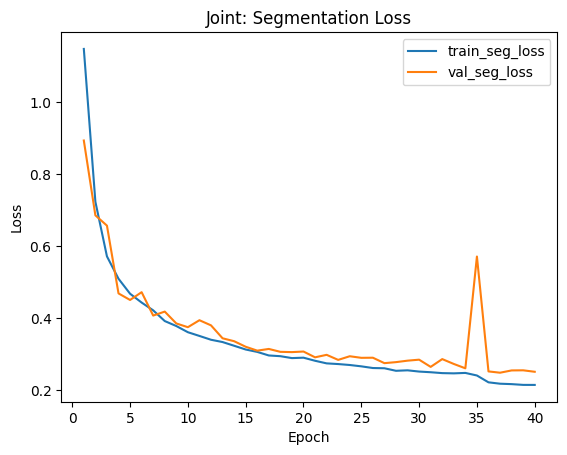

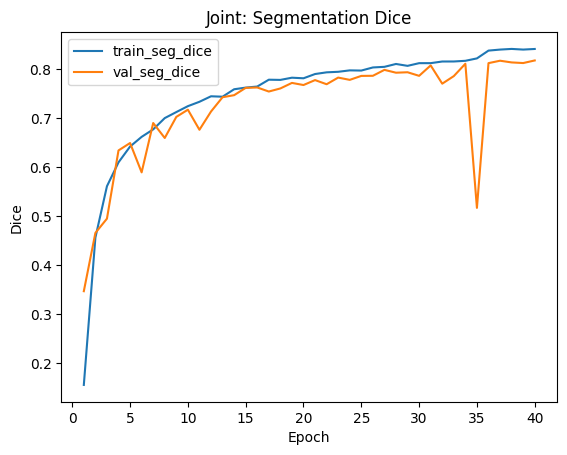

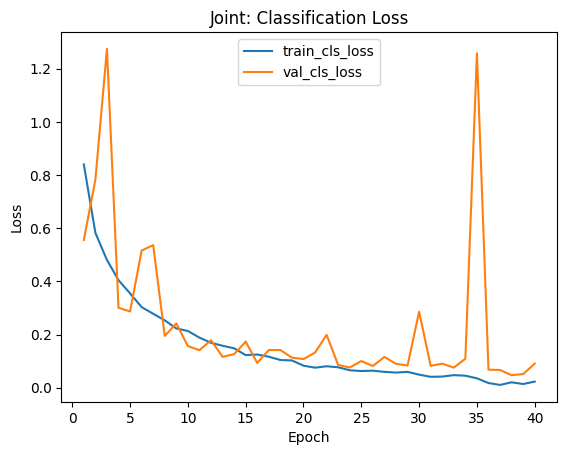

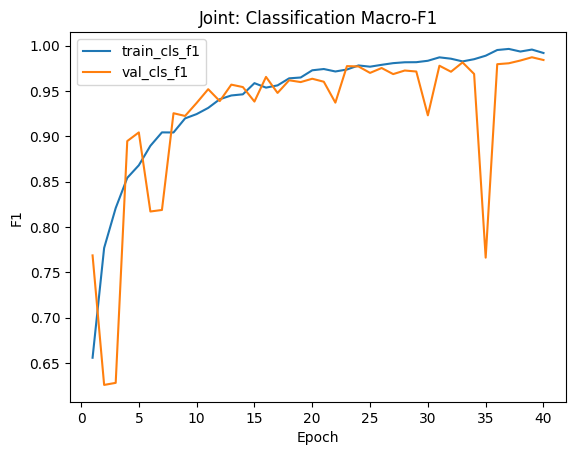

In [ ]:
#  Joint training curves (loss + key metrics)

import numpy as np
import matplotlib.pyplot as plt

ep = np.arange(1, len(hist["train_seg_loss"]) + 1)

plt.figure()
plt.plot(ep, hist["train_seg_loss"], label="train_seg_loss")
plt.plot(ep, hist["val_seg_loss"], label="val_seg_loss")
plt.title("Joint: Segmentation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(ep, hist["train_seg_dice"], label="train_seg_dice")
plt.plot(ep, hist["val_seg_dice"], label="val_seg_dice")
plt.title("Joint: Segmentation Dice")
plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.legend(); plt.show()

plt.figure()
plt.plot(ep, hist["train_cls_loss"], label="train_cls_loss")
plt.plot(ep, hist["val_cls_loss"], label="val_cls_loss")
plt.title("Joint: Classification Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(ep, hist["train_cls_f1"], label="train_cls_f1")
plt.plot(ep, hist["val_cls_f1"], label="val_cls_f1")
plt.title("Joint: Classification Macro-F1")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend(); plt.show()


inferance

In [ ]:
CODE_TO_LABEL = {"gl": "glioma", "me": "meningioma", "pi": "pituitary", "nt": "no_tumor"}

def infer_true_label(image_path: str):

    parts = image_path.replace("\\", "/").split("/")
    if "classification_task" in parts:
        i = parts.index("classification_task")
        if i + 2 < len(parts):
            split = parts[i + 1]
            lab = parts[i + 2]
            if split in ("train", "test"):
                return lab


    fname = os.path.basename(image_path)
    toks = fname.split("_")
    if len(toks) >= 4:
        code = toks[3].lower()
        return CODE_TO_LABEL.get(code, None)

    return None

def find_gt_mask(image_path: str, data_root: str):
    base = os.path.splitext(os.path.basename(image_path))[0] + ".png"
    for c in [
        os.path.join(data_root, "segmentation_task/train/masks", base),
        os.path.join(data_root, "segmentation_task/test/masks", base),
    ]:
        if os.path.exists(c):
            return c
    return None

@torch.no_grad()
def demo_joint_project_inference(
    image_path: str,
    joint_model,
    label_map,
    img_size=(384, 384),
    thr=0.5,
    data_root="/kaggle/input/brisc2025/brisc2025",
):
    joint_model.eval()
    device = next(joint_model.parameters()).device

    # ---- load + processed (resize) ----
    img_orig = Image.open(image_path).convert("L")
    img_proc = TF.resize(img_orig, img_size, interpolation=InterpolationMode.BILINEAR)
    x = TF.to_tensor(img_proc).unsqueeze(0).to(device)

    # ---- GT mask  ----
    mask_path = find_gt_mask(image_path, data_root)
    gt_mask = None
    if mask_path is not None:
        m = Image.open(mask_path).convert("L")
        m = TF.resize(m, img_size, interpolation=InterpolationMode.NEAREST)
        gt_mask = (np.array(m) > 0).astype(np.float32)

    # ---- joint predictions ----
    seg_logits = joint_model.forward_seg(x)
    seg_prob = torch.sigmoid(seg_logits)[0, 0].detach().cpu().numpy()
    pred_mask = (seg_prob > thr).astype(np.float32)

    cls_logits = joint_model.forward_cls(x)
    probs = torch.softmax(cls_logits, dim=1)[0].detach().cpu().numpy()
    pred_id = int(np.argmax(probs))
    pred_label = label_map.id_to_label[pred_id]
    pred_conf = float(probs[pred_id])


    iou = None
    if gt_mask is not None:
        tp = (pred_mask * gt_mask).sum()
        fp = (pred_mask * (1 - gt_mask)).sum()
        fn = ((1 - pred_mask) * gt_mask).sum()
        eps = 1e-7
        iou = float((tp + eps) / (tp + fp + fn + eps))

    # ---- given/predicted + single-image cls "accuracy"  ----
    given = infer_true_label(image_path)
    cls_acc = None
    if given is not None:
        cls_acc = 1.0 if pred_label == given else 0.0

    # ---- plot: exact 2×3 project layout ----
    img_np = np.array(img_proc)
    fig, ax = plt.subplots(2, 3, figsize=(14, 8))

    ax[0, 0].imshow(img_np, cmap="gray"); ax[0, 0].set_title("Original image"); ax[0, 0].axis("off")

    if gt_mask is None:
        ax[0, 1].imshow(np.zeros_like(img_np), cmap="gray")
    else:
        ax[0, 1].imshow(gt_mask, cmap="jet")
    ax[0, 1].set_title("Original mask"); ax[0, 1].axis("off")

    ax[0, 2].imshow(img_np, cmap="gray")
    if gt_mask is not None:
        ax[0, 2].imshow(gt_mask, cmap="jet", alpha=0.35)
    ax[0, 2].set_title("Original image with mask overlay"); ax[0, 2].axis("off")

    ax[1, 0].imshow(img_np, cmap="gray")
    ax[1, 0].set_title("Processed image ")
    ax[1, 0].axis("off")

    ax[1, 1].imshow(pred_mask, cmap="jet"); ax[1, 1].set_title("Predicted mask"); ax[1, 1].axis("off")

    ax[1, 2].imshow(img_np, cmap="gray")
    ax[1, 2].imshow(pred_mask, cmap="jet", alpha=0.35)
    ax[1, 2].set_title("Original image with predicted mask overlay"); ax[1, 2].axis("off")

    given_txt = "N/A" if given is None else given
    acc_txt   = "N/A" if cls_acc is None else f"{cls_acc:.2f}"
    iou_txt   = "N/A" if iou is None else f"{iou:.3f}"
    fig.suptitle(
        f"given: {given_txt}   predicted: {pred_label} ({pred_conf:.2f})   classification accuracy - {acc_txt}   IoU - {iou_txt}",
        fontsize=13
    )

    plt.tight_layout()
    plt.show()


Demo image: /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00792_pi_ax_t1.jpg


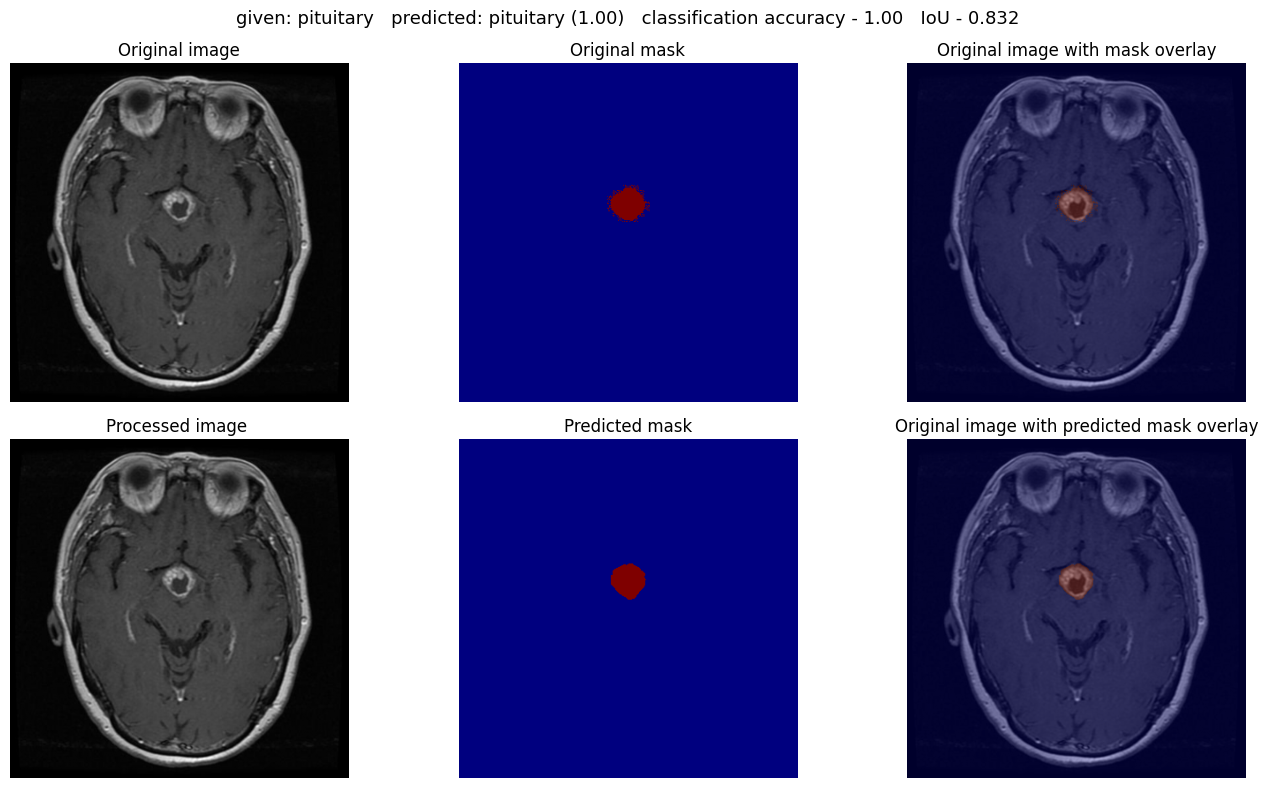

In [ ]:

DATA_ROOT = "/kaggle/input/brisc2025/brisc2025"
IMG_SIZE  = (384, 384)

JOINT_CKPT = "/kaggle/working/joint_multitask_best.pth"

# ---- load joint model ----
joint_model = MultiTaskUNet(in_ch=1, base=32, num_classes=len(label_map.labels)).to(DEVICE)
joint_model.load_state_dict(torch.load(JOINT_CKPT, map_location=DEVICE))

# --------- A) RANDOM IMAGE (seg test) ----------
img_dir = f"{DATA_ROOT}/segmentation_task/test/images"
files = [f for f in os.listdir(img_dir) if f.lower().endswith((".png",".jpg",".jpeg"))]
DEMO_IMAGE_PATH = os.path.join(img_dir, random.choice(files))

# --------- B) MANUAL IMAGE  ----------
# DEMO_IMAGE_PATH = "/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/xxxx.jpg"

print("Demo image:", DEMO_IMAGE_PATH)

demo_joint_project_inference(
    image_path=DEMO_IMAGE_PATH,
    joint_model=joint_model,
    label_map=label_map,
    img_size=IMG_SIZE,
    thr=0.5,
    data_root=DATA_ROOT,
)


Analysis:

Compared to training the segmentation and classification heads separately, joint training with a shared encoder gave better overall performance and the loss curves support that trend. In the separate setup, Stage-1 segmentation loss decreased smoothly and stabilized (with val loss tracking train loss closely), and the final segmentation metrics were strong (test mIoU = 0.8411, Dice = 0.8165, pixel accuracy = 0.9924). However, the Stage-2 classifier (trained after freezing the encoder) showed a slower decrease and a clear gap between train and validation loss, ending with much lower classification performance (test accuracy = 0.7930, F1 = 0.7923).

In joint training, both the segmentation and classification losses generally decreased together and stayed low for most epochs (even though there were a few short validation spikes later in training), and the best checkpoint produced higher test performance on both tasks: segmentation improved slightly (test mIoU = 0.8510, Dice = 0.8297, pixel accuracy = 0.9931) while classification improved dramatically (test accuracy = 0.9740, F1 = 0.9740). Overall, based on both the loss-curve behavior and the final test metrics, the joint training approach was clearly better, especially for classification, while also providing a modest gain in segmentation quality.

joint training improve classification because:
 the encoder learns class-discriminative features directly from classification loss, instead of being frozen after segmentation-only training.

 segmentation also improve slightly because:

Multi-task learning acts like a regularizer: classification encourages encoder to learn robust global features that can also help segmentation generalization.

Bonus 2

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_ROOT = "/kaggle/input/brisc2025/brisc2025"
CLS_TRAIN_DIR = f"{DATA_ROOT}/classification_task/train"
CLS_TEST_DIR  = f"{DATA_ROOT}/classification_task/test"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
PATIENCE = 5
LR = 1e-3

LABELS = ["glioma", "meningioma", "pituitary", "no_tumor"]
LABEL_TO_ID = {l:i for i,l in enumerate(LABELS)}
ID_TO_LABEL = {i:l for l,i in LABEL_TO_ID.items()}

print("Device:", DEVICE)
print("Train dir:", CLS_TRAIN_DIR)
print("Test  dir:", CLS_TEST_DIR)

Device: cuda
Train dir: /kaggle/input/brisc2025/brisc2025/classification_task/train
Test  dir: /kaggle/input/brisc2025/brisc2025/classification_task/test


In [ ]:
# =========================================================
# Build dataframe + stratified train/val split
# =========================================================
from sklearn.model_selection import train_test_split

def build_cls_df(folder):
    rows = []
    for lab in LABELS:
        lab_dir = os.path.join(folder, lab)
        if not os.path.isdir(lab_dir):
            continue
        for fn in os.listdir(lab_dir):
            if fn.lower().endswith((".png",".jpg",".jpeg")):
                rows.append({"path": os.path.join(lab_dir, fn), "label": lab, "y": LABEL_TO_ID[lab]})
    return pd.DataFrame(rows)

df_train_full = build_cls_df(CLS_TRAIN_DIR)
df_test = build_cls_df(CLS_TEST_DIR)

df_train, df_val = train_test_split(
    df_train_full,
    test_size=0.2,
    random_state=SEED,
    stratify=df_train_full["y"]
)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
df_train.head()


Train: 4000 Val: 1000 Test: 1000


path       label  y
1387  /kaggle/input/brisc2025/brisc2025/classificati...  meningioma  1
1783  /kaggle/input/brisc2025/brisc2025/classificati...  meningioma  1
4829  /kaggle/input/brisc2025/brisc2025/classificati...    no_tumor  3
2021  /kaggle/input/brisc2025/brisc2025/classificati...  meningioma  1
277   /kaggle/input/brisc2025/brisc2025/classificati...      glioma  0

In [ ]:
# =========================================================
# convert to 3-channel
# =========================================================
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class BriscClsDatasetRGB(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        p = self.df.loc[idx, "path"]
        y = int(self.df.loc[idx, "y"])
        # convert to RGB (repeats grayscale into 3 channels)
        img = Image.open(p).convert("RGB")
        x = self.transform(img)
        return x, y


In [ ]:
# =========================================================
# DataLoaders
# =========================================================
train_loader = DataLoader(BriscClsDatasetRGB(df_train, train_tfms), batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(BriscClsDatasetRGB(df_val,   eval_tfms),  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(BriscClsDatasetRGB(df_test,  eval_tfms),  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
# =========================================================
#  Metrics helpers (acc, precision_macro, recall_macro, f1_macro)
# =========================================================
def cls_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    return float(acc), float(p), float(r), float(f1)


In [ ]:
# =========================================================
#  MobileNetV2, EfficientNet-B0, DenseNet121
# =========================================================
def _try_weights(getter):
    try:
        return getter.DEFAULT
    except Exception:
        return None

def get_model(model_name: str, num_classes: int):
    model_name = model_name.lower()

    if model_name == "mobilenetv2":
        weights = _try_weights(torchvision.models.MobileNet_V2_Weights)
        try:
            m = torchvision.models.mobilenet_v2(weights=weights)
        except Exception:
            m = torchvision.models.mobilenet_v2(weights=None)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
        return m

    if model_name == "efficientnetb0":
        weights = _try_weights(torchvision.models.EfficientNet_B0_Weights)
        try:
            m = torchvision.models.efficientnet_b0(weights=weights)
        except Exception:
            m = torchvision.models.efficientnet_b0(weights=None)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
        return m

    if model_name == "densenet121":
        weights = _try_weights(torchvision.models.DenseNet121_Weights)
        try:
            m = torchvision.models.densenet121(weights=weights)
        except Exception:
            m = torchvision.models.densenet121(weights=None)
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)
        return m

    raise ValueError("Unknown model_name. Use: mobilenetv2, efficientnetb0, densenet121")


In [ ]:
# =========================================================
# Train/Eval one epoch
# =========================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        all_true.extend(y.detach().cpu().numpy().tolist())
        all_pred.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())

    avg_loss = total_loss / len(loader.dataset)
    acc, p, r, f1 = cls_metrics(all_true, all_pred)
    return avg_loss, acc, p, r, f1

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        all_true.extend(y.detach().cpu().numpy().tolist())
        all_pred.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())

    avg_loss = total_loss / len(loader.dataset)
    acc, p, r, f1 = cls_metrics(all_true, all_pred)
    return avg_loss, acc, p, r, f1


In [ ]:
# =========================================================
#  Full training runner for 1 architecture
# =========================================================
def train_model(model_name: str):
    model = get_model(model_name, num_classes=len(LABELS)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_val_f1 = -1.0
    best_path = f"/kaggle/working/{model_name}_best.pth"
    no_improve = 0

    hist = {"train_loss": [], "val_loss": [], "train_f1": [], "val_f1": []}

    for epoch in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, criterion)
        va = eval_one_epoch(model, val_loader, criterion)

        tr_loss, tr_acc, tr_p, tr_r, tr_f1 = tr
        va_loss, va_acc, va_p, va_r, va_f1 = va

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_f1"].append(tr_f1)
        hist["val_f1"].append(va_f1)

        print(f"[{model_name}] Epoch {epoch:02d}/{EPOCHS} | "
              f"loss {tr_loss:.4f}/{va_loss:.4f} | "
              f"acc {tr_acc:.4f}/{va_acc:.4f} | "
              f"F1 {tr_f1:.4f}/{va_f1:.4f}")

        if va_f1 > best_val_f1 + 1e-4:
            best_val_f1 = va_f1
            no_improve = 0
            torch.save(model.state_dict(), best_path)
            print(f"Saved best: {best_path} (val_F1={best_val_f1:.4f})")
        else:
            no_improve += 1

        if no_improve >= PATIENCE:
            print(f"  Early stopping (no improve for {PATIENCE} epochs).")
            break

    # Load best + final summaries
    model.load_state_dict(torch.load(best_path, map_location=DEVICE))

    tr = eval_one_epoch(model, train_loader, criterion)
    va = eval_one_epoch(model, val_loader, criterion)
    te = eval_one_epoch(model, test_loader, criterion)

    summary = pd.DataFrame(
        [["train", *tr], ["val", *va], ["test", *te]],
        columns=["split", "loss", "accuracy", "precision_macro", "recall_macro", "f1_macro"]
    )
    return model, best_path, hist, summary


In [ ]:
# =========================================================
#  3 architectures + show comparison table
# =========================================================
models_to_try = ["mobilenetv2", "efficientnetb0", "densenet121"]

all_summaries = []
all_histories = {}
best_paths = {}

for name in models_to_try:
    model, path, hist, summary = train_model(name)
    best_paths[name] = path
    all_histories[name] = hist

    # keep ONLY test row for the final comparison table
    test_row = summary[summary["split"] == "test"].copy()
    test_row.insert(0, "model", name)
    all_summaries.append(test_row)

comparison = pd.concat(all_summaries, ignore_index=True)
comparison


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 193MB/s]


[mobilenetv2] Epoch 01/15 | loss 0.2929/0.1690 | acc 0.8945/0.9320 | F1 0.8950/0.9332
Saved best: /kaggle/working/mobilenetv2_best.pth (val_F1=0.9332)
[mobilenetv2] Epoch 02/15 | loss 0.1337/0.1614 | acc 0.9510/0.9520 | F1 0.9516/0.9525
Saved best: /kaggle/working/mobilenetv2_best.pth (val_F1=0.9525)
[mobilenetv2] Epoch 03/15 | loss 0.1071/0.1405 | acc 0.9635/0.9580 | F1 0.9640/0.9583
Saved best: /kaggle/working/mobilenetv2_best.pth (val_F1=0.9583)
[mobilenetv2] Epoch 04/15 | loss 0.0890/0.0934 | acc 0.9708/0.9710 | F1 0.9707/0.9717
Saved best: /kaggle/working/mobilenetv2_best.pth (val_F1=0.9717)
[mobilenetv2] Epoch 05/15 | loss 0.0715/0.2385 | acc 0.9755/0.9310 | F1 0.9761/0.9292
[mobilenetv2] Epoch 06/15 | loss 0.0599/0.0507 | acc 0.9790/0.9820 | F1 0.9792/0.9819
Saved best: /kaggle/working/mobilenetv2_best.pth (val_F1=0.9819)
[mobilenetv2] Epoch 07/15 | loss 0.0542/0.0694 | acc 0.9808/0.9810 | F1 0.9810/0.9815
[mobilenetv2] Epoch 08/15 | loss 0.0393/0.0905 | acc 0.9872/0.9720 | F1 0

100%|██████████| 20.5M/20.5M [00:00<00:00, 186MB/s]


[efficientnetb0] Epoch 01/15 | loss 0.2928/0.1666 | acc 0.9022/0.9400 | F1 0.9032/0.9422
Saved best: /kaggle/working/efficientnetb0_best.pth (val_F1=0.9422)
[efficientnetb0] Epoch 02/15 | loss 0.1482/0.1467 | acc 0.9475/0.9570 | F1 0.9483/0.9593
Saved best: /kaggle/working/efficientnetb0_best.pth (val_F1=0.9593)
[efficientnetb0] Epoch 03/15 | loss 0.0738/0.0603 | acc 0.9750/0.9740 | F1 0.9753/0.9746
Saved best: /kaggle/working/efficientnetb0_best.pth (val_F1=0.9746)
[efficientnetb0] Epoch 04/15 | loss 0.0821/0.0623 | acc 0.9710/0.9800 | F1 0.9716/0.9803
Saved best: /kaggle/working/efficientnetb0_best.pth (val_F1=0.9803)
[efficientnetb0] Epoch 05/15 | loss 0.0650/0.0886 | acc 0.9780/0.9810 | F1 0.9780/0.9815
Saved best: /kaggle/working/efficientnetb0_best.pth (val_F1=0.9815)
[efficientnetb0] Epoch 06/15 | loss 0.0521/0.1009 | acc 0.9800/0.9670 | F1 0.9800/0.9688
[efficientnetb0] Epoch 07/15 | loss 0.0660/0.0459 | acc 0.9802/0.9820 | F1 0.9803/0.9828
Saved best: /kaggle/working/efficient

100%|██████████| 30.8M/30.8M [00:00<00:00, 221MB/s]


[densenet121] Epoch 01/15 | loss 0.3506/0.2808 | acc 0.8762/0.9080 | F1 0.8780/0.9115
Saved best: /kaggle/working/densenet121_best.pth (val_F1=0.9115)
[densenet121] Epoch 02/15 | loss 0.1879/1.3022 | acc 0.9317/0.5840 | F1 0.9327/0.5740
[densenet121] Epoch 03/15 | loss 0.1531/0.2172 | acc 0.9440/0.9280 | F1 0.9447/0.9280
Saved best: /kaggle/working/densenet121_best.pth (val_F1=0.9280)
[densenet121] Epoch 04/15 | loss 0.1515/0.4000 | acc 0.9465/0.8570 | F1 0.9472/0.8597
[densenet121] Epoch 05/15 | loss 0.1119/0.1363 | acc 0.9607/0.9550 | F1 0.9614/0.9560
Saved best: /kaggle/working/densenet121_best.pth (val_F1=0.9560)
[densenet121] Epoch 06/15 | loss 0.0783/0.1517 | acc 0.9752/0.9520 | F1 0.9753/0.9533
[densenet121] Epoch 07/15 | loss 0.1070/0.1375 | acc 0.9615/0.9560 | F1 0.9619/0.9567
Saved best: /kaggle/working/densenet121_best.pth (val_F1=0.9567)
[densenet121] Epoch 08/15 | loss 0.0659/0.1635 | acc 0.9768/0.9470 | F1 0.9771/0.9473
[densenet121] Epoch 09/15 | loss 0.0842/0.1283 | acc

model split      loss  accuracy  precision_macro  recall_macro  \
0     mobilenetv2  test  0.077087     0.972         0.971446      0.976239   
1  efficientnetb0  test  0.048817     0.988         0.986696      0.989796   
2     densenet121  test  0.068688     0.980         0.977172      0.982942   

   f1_macro  
0  0.973552  
1  0.988206  
2  0.979903

In [ ]:
# =========================================================
# clean comparison
# =========================================================
comparison_sorted = comparison.sort_values(by="f1_macro", ascending=False)

print(comparison_sorted.to_string(index=False))
print("\nBest checkpoints:", best_paths)


         model split     loss  accuracy  precision_macro  recall_macro  f1_macro
efficientnetb0  test 0.048817     0.988         0.986696      0.989796  0.988206
   densenet121  test 0.068688     0.980         0.977172      0.982942  0.979903
   mobilenetv2  test 0.077087     0.972         0.971446      0.976239  0.973552

Best checkpoints: {'mobilenetv2': '/kaggle/working/mobilenetv2_best.pth', 'efficientnetb0': '/kaggle/working/efficientnetb0_best.pth', 'densenet121': '/kaggle/working/densenet121_best.pth'}


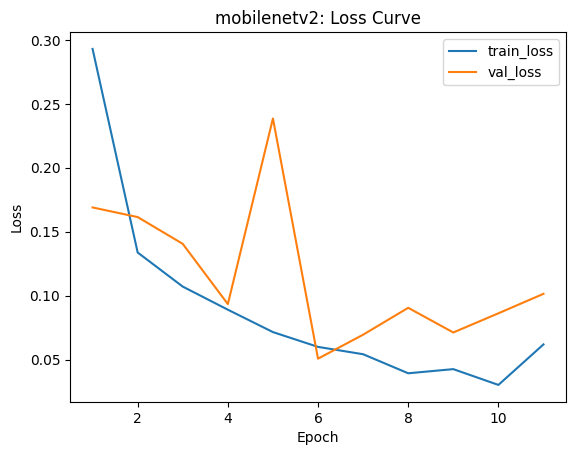

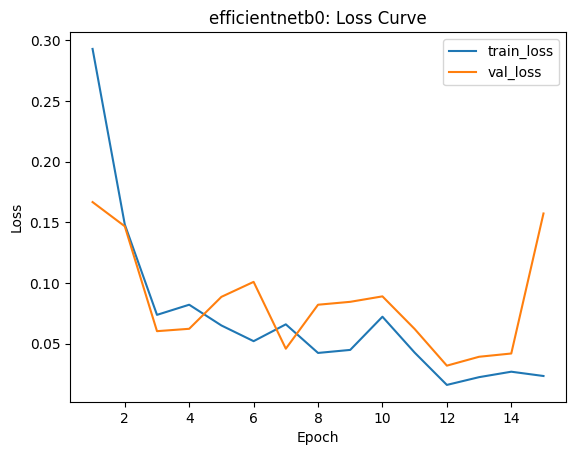

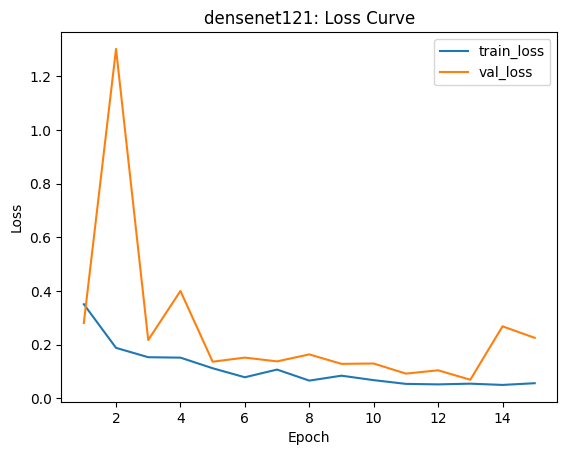

In [ ]:
# =========================================================
#  Loss curves (train vs val) for the 3 architectures

for name in models_to_try:
    hist = all_histories[name]
    ep = np.arange(1, len(hist["train_loss"]) + 1)

    plt.figure()
    plt.plot(ep, hist["train_loss"], label="train_loss")
    plt.plot(ep, hist["val_loss"], label="val_loss")
    plt.title(f"{name}: Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
